In [1]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn import metrics
from sklearn.metrics import roc_auc_score

# import matplotlib.pyplot as plt

from sklearn.externals import joblib

In [19]:
import matplotlib.pyplot as plt

In [2]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [3]:
from sklearn.metrics import accuracy_score

In [4]:
import pandas as pd
import numpy as np

### Model trainig with hyper-parameter tuning

In [24]:
## Model developed to be used in for loop without print statement

def model_fit_hyperopt(params):
    
#     attempt_count += 1

    ### Asssigning default parameters
    useTrainCV = False
    cv_folds = 5
    early_stopping_rounds = 50
    
    ### Forming copy of input datasets
    train_c, valid_c, test_c = train.copy(), valid.copy(), test.copy()
#     out_path = params['out_path']
    predictors, target = list(params['predictors']), params['target']
    
    alg = XGBClassifier(
                learning_rate =params['learning_rate'],
                n_estimators=params['n_estimators'],
                max_depth=params['max_depth'],
                min_child_weight=params['min_child_weight'],
                gamma=params['gamma'],
                subsample=params['subsample'],
                colsample_bytree=params['colsample_bytree'],
                objective= 'binary:logistic',
                scale_pos_weight=params['scale_pos_weight'],
                seed=27)

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(train_c[predictors].values, label=train_c[target].values)
        xgtest = xgb.DMatrix(valid_c[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics = 'auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False, seed=27)
        ne_new = n_estimators=cvresult.shape[0]
        alg.set_params(n_estimators=cvresult.shape[0])
        
    #Fit the algorithm on the data
    eval_set = [(valid_c[predictors],valid_c[target])]
    alg.fit(train_c[predictors], train_c[target],eval_metric='auc', early_stopping_rounds=early_stopping_rounds, eval_set = eval_set, verbose = True)     
    
    valid_c.loc[:,'prob'] = alg.predict_proba(valid_c[predictors])[:,1]
    test_c.loc[:,'prob'] = alg.predict_proba(test_c[predictors])[:,1]
    
    valid_auc = roc_auc_score(np.array(valid_c.loc[:,target]), np.array(valid_c.loc[:,'prob']))
    test_auc = roc_auc_score(np.array(test_c.loc[:,target]), np.array(test_c.loc[:,'prob']))
    loss = 1 - valid_auc
    
#     if out_path != None:
#         f = open(os.path.join(out_path, "hyperopt_logs.txt"), "a+")
#         f.write("Valid AUC: {} and Test AUC: {}, loss: {}".format(valid_auc,test_auc,loss))
#         f.close()
    
    print ("Valid AUC: {} and Test AUC: {}, Loss: {}".format(valid_auc, test_auc, loss))
    
    return {'loss': loss, 'status': STATUS_OK, 'params': params, 'model':alg}

In [6]:
def get_best_model_xgb(space, train, valid, test):
    
#     f = open(os.path.join(out_path, "hyperopt_logs.txt"), "w+")
#     f.close()

    trials=Trials()
    best = fmin(model_fit_hyperopt, space, algo=tpe.suggest, max_evals=75, trials=trials)
    
    return trials.best_trial['result']['model'], trials.best_trial['result']

### How the function is called 

In [7]:
def train_validate_test_split(df, train_percent=.60, validate_percent=.20, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [8]:
def data(df,target):
    processed_df = pd.get_dummies(df,sparse=True)
    df_features = list(set(processed_df.columns) - set([target]))
    train, valid, test = train_validate_test_split(processed_df)
    return train, valid, test, df_features, target

In [9]:
first_df = pd.read_csv('first_insurance_data.csv',index_col=0)

/home/ambuj/izenda_fullcycle/izenda_insurance_data/insurance_env/lib/python3.5/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [23]:
first_df_sample = first_df.head(10000)

In [25]:
train, valid, test, df_features, df_target = data(first_df_sample,target='NewEstimateTotal')

space = {'learning_rate': hp.choice('learning_rate',[0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1]),
                     'n_estimators': hp.choice('n_estimators', [500, 1000, 2000, 5000]),
                     'min_child_weight': hp.choice('min_child_weight', [0,1,2,3,4,5,6,7]),
                     'max_depth': hp.choice('max_depth', [3,4,5,6,7,8,9,10]),
                     'gamma': hp.choice('gamma', [0,1,5,10]),
                     'subsample': hp.choice('subsample',np.arange(0.4,1.05,0.1)),
                     'colsample_bytree': hp.choice('colsample_bytree',np.arange(0.5,1.05,0.1)),
                     'scale_pos_weight': (len(train) -train[df_target].sum())/train[df_target].sum(),
                     'predictors': df_features,
                     'target': df_target
        }

best_first_trained, first_trials = get_best_model_xgb(space, train, valid, test)

[0]	validation_0-auc:0.869689
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.899388
[2]	validation_0-auc:0.915969
[3]	validation_0-auc:0.914496
[4]	validation_0-auc:0.913236
[5]	validation_0-auc:0.916939
[6]	validation_0-auc:0.920305
[7]	validation_0-auc:0.919293
[8]	validation_0-auc:0.919496
[9]	validation_0-auc:0.923215
[10]	validation_0-auc:0.923428
[11]	validation_0-auc:0.92272
[12]	validation_0-auc:0.920646
[13]	validation_0-auc:0.91975
[14]	validation_0-auc:0.919836
[15]	validation_0-auc:0.921222
[16]	validation_0-auc:0.922494
[17]	validation_0-auc:0.922646
[18]	validation_0-auc:0.920795
[19]	validation_0-auc:0.920498
[20]	validation_0-auc:0.922103
[21]	validation_0-auc:0.922919
[22]	validation_0-auc:0.922411
[23]	validation_0-auc:0.921877
[24]	validation_0-auc:0.9226
[25]	validation_0-auc:0.920723
[26]	validation_0-auc:0.920121
[27]	validation_0-auc:0.919995
[28]	validation_0-auc:0.918492
[29]	validation_0-auc:0.91884
[30]	validation_0-auc

[115]	validation_0-auc:0.878164
[116]	validation_0-auc:0.87828
[117]	validation_0-auc:0.87823
[118]	validation_0-auc:0.878551
[119]	validation_0-auc:0.878619
[120]	validation_0-auc:0.878853
[121]	validation_0-auc:0.878919
[122]	validation_0-auc:0.879186
[123]	validation_0-auc:0.879427
[124]	validation_0-auc:0.879742
[125]	validation_0-auc:0.880039
[126]	validation_0-auc:0.880251
[127]	validation_0-auc:0.880351
[128]	validation_0-auc:0.880324
[129]	validation_0-auc:0.88051
[130]	validation_0-auc:0.880704
[131]	validation_0-auc:0.880542
[132]	validation_0-auc:0.880451
[133]	validation_0-auc:0.880443
[134]	validation_0-auc:0.880717
[135]	validation_0-auc:0.881037
[136]	validation_0-auc:0.881166
[137]	validation_0-auc:0.881178
[138]	validation_0-auc:0.881182
[139]	validation_0-auc:0.8813
[140]	validation_0-auc:0.881517
[141]	validation_0-auc:0.881745
[142]	validation_0-auc:0.882046
[143]	validation_0-auc:0.882198
[144]	validation_0-auc:0.882193
[145]	validation_0-auc:0.88235
[146]	validati

[372]	validation_0-auc:0.900782
[373]	validation_0-auc:0.900794
[374]	validation_0-auc:0.900882
[375]	validation_0-auc:0.900907
[376]	validation_0-auc:0.900939
[377]	validation_0-auc:0.900952
[378]	validation_0-auc:0.901127
[379]	validation_0-auc:0.901167
[380]	validation_0-auc:0.901158
[381]	validation_0-auc:0.901232
[382]	validation_0-auc:0.901316
[383]	validation_0-auc:0.901314
[384]	validation_0-auc:0.901282
[385]	validation_0-auc:0.901331
[386]	validation_0-auc:0.901339
[387]	validation_0-auc:0.901355
[388]	validation_0-auc:0.901382
[389]	validation_0-auc:0.901412
[390]	validation_0-auc:0.901441
[391]	validation_0-auc:0.901499
[392]	validation_0-auc:0.901555
[393]	validation_0-auc:0.901565
[394]	validation_0-auc:0.901565
[395]	validation_0-auc:0.901705
[396]	validation_0-auc:0.90177
[397]	validation_0-auc:0.90183
[398]	validation_0-auc:0.901852
[399]	validation_0-auc:0.901885
[400]	validation_0-auc:0.901899
[401]	validation_0-auc:0.901959
[402]	validation_0-auc:0.902016
[403]	vali

[629]	validation_0-auc:0.909638
[630]	validation_0-auc:0.909624
[631]	validation_0-auc:0.90966
[632]	validation_0-auc:0.909661
[633]	validation_0-auc:0.909697
[634]	validation_0-auc:0.909728
[635]	validation_0-auc:0.909789
[636]	validation_0-auc:0.909751
[637]	validation_0-auc:0.909778
[638]	validation_0-auc:0.909828
[639]	validation_0-auc:0.909862
[640]	validation_0-auc:0.90987
[641]	validation_0-auc:0.909932
[642]	validation_0-auc:0.909947
[643]	validation_0-auc:0.910009
[644]	validation_0-auc:0.910018
[645]	validation_0-auc:0.910069
[646]	validation_0-auc:0.910088
[647]	validation_0-auc:0.910137
[648]	validation_0-auc:0.910188
[649]	validation_0-auc:0.910226
[650]	validation_0-auc:0.91026
[651]	validation_0-auc:0.910297
[652]	validation_0-auc:0.91032
[653]	validation_0-auc:0.910299
[654]	validation_0-auc:0.910361
[655]	validation_0-auc:0.910427
[656]	validation_0-auc:0.910443
[657]	validation_0-auc:0.910403
[658]	validation_0-auc:0.9104
[659]	validation_0-auc:0.910458
[660]	validati

[887]	validation_0-auc:0.914623
[888]	validation_0-auc:0.914608
[889]	validation_0-auc:0.914628
[890]	validation_0-auc:0.914596
[891]	validation_0-auc:0.914569
[892]	validation_0-auc:0.914575
[893]	validation_0-auc:0.914619
[894]	validation_0-auc:0.914636
[895]	validation_0-auc:0.914638
[896]	validation_0-auc:0.914665
[897]	validation_0-auc:0.914678
[898]	validation_0-auc:0.914727
[899]	validation_0-auc:0.914732
[900]	validation_0-auc:0.914785
[901]	validation_0-auc:0.914761
[902]	validation_0-auc:0.914819
[903]	validation_0-auc:0.914813
[904]	validation_0-auc:0.914873
[905]	validation_0-auc:0.914886
[906]	validation_0-auc:0.914926
[907]	validation_0-auc:0.914941
[908]	validation_0-auc:0.914969
[909]	validation_0-auc:0.91496
[910]	validation_0-auc:0.915019
[911]	validation_0-auc:0.914988
[912]	validation_0-auc:0.914978
[913]	validation_0-auc:0.91499
[914]	validation_0-auc:0.915008
[915]	validation_0-auc:0.915031
[916]	validation_0-auc:0.915002
[917]	validation_0-auc:0.915057
[918]	vali

[1140]	validation_0-auc:0.917527
[1141]	validation_0-auc:0.917566
[1142]	validation_0-auc:0.917534
[1143]	validation_0-auc:0.917567
[1144]	validation_0-auc:0.917586
[1145]	validation_0-auc:0.917598
[1146]	validation_0-auc:0.917627
[1147]	validation_0-auc:0.917639
[1148]	validation_0-auc:0.917638
[1149]	validation_0-auc:0.917643
[1150]	validation_0-auc:0.917664
[1151]	validation_0-auc:0.917666
[1152]	validation_0-auc:0.917661
[1153]	validation_0-auc:0.917664
[1154]	validation_0-auc:0.917656
[1155]	validation_0-auc:0.917708
[1156]	validation_0-auc:0.917708
[1157]	validation_0-auc:0.917715
[1158]	validation_0-auc:0.917763
[1159]	validation_0-auc:0.917826
[1160]	validation_0-auc:0.917835
[1161]	validation_0-auc:0.917852
[1162]	validation_0-auc:0.917908
[1163]	validation_0-auc:0.917916
[1164]	validation_0-auc:0.91791
[1165]	validation_0-auc:0.917908
[1166]	validation_0-auc:0.917884
[1167]	validation_0-auc:0.917864
[1168]	validation_0-auc:0.917853
[1169]	validation_0-auc:0.91786
[1170]	valid

[1390]	validation_0-auc:0.920221
[1391]	validation_0-auc:0.920258
[1392]	validation_0-auc:0.920237
[1393]	validation_0-auc:0.920241
[1394]	validation_0-auc:0.920264
[1395]	validation_0-auc:0.920247
[1396]	validation_0-auc:0.920271
[1397]	validation_0-auc:0.920328
[1398]	validation_0-auc:0.92034
[1399]	validation_0-auc:0.920358
[1400]	validation_0-auc:0.920352
[1401]	validation_0-auc:0.92037
[1402]	validation_0-auc:0.920368
[1403]	validation_0-auc:0.92035
[1404]	validation_0-auc:0.920377
[1405]	validation_0-auc:0.920387
[1406]	validation_0-auc:0.920382
[1407]	validation_0-auc:0.920412
[1408]	validation_0-auc:0.920387
[1409]	validation_0-auc:0.920435
[1410]	validation_0-auc:0.92043
[1411]	validation_0-auc:0.920432
[1412]	validation_0-auc:0.920443
[1413]	validation_0-auc:0.920415
[1414]	validation_0-auc:0.920434
[1415]	validation_0-auc:0.920457
[1416]	validation_0-auc:0.920476
[1417]	validation_0-auc:0.92049
[1418]	validation_0-auc:0.920488
[1419]	validation_0-auc:0.92049
[1420]	validatio

[1640]	validation_0-auc:0.922029
[1641]	validation_0-auc:0.92205
[1642]	validation_0-auc:0.92205
[1643]	validation_0-auc:0.922081
[1644]	validation_0-auc:0.922105
[1645]	validation_0-auc:0.922133
[1646]	validation_0-auc:0.922182
[1647]	validation_0-auc:0.922169
[1648]	validation_0-auc:0.922171
[1649]	validation_0-auc:0.922173
[1650]	validation_0-auc:0.922196
[1651]	validation_0-auc:0.922207
[1652]	validation_0-auc:0.92221
[1653]	validation_0-auc:0.922218
[1654]	validation_0-auc:0.922221
[1655]	validation_0-auc:0.922263
[1656]	validation_0-auc:0.922286
[1657]	validation_0-auc:0.922287
[1658]	validation_0-auc:0.922276
[1659]	validation_0-auc:0.92226
[1660]	validation_0-auc:0.922255
[1661]	validation_0-auc:0.922274
[1662]	validation_0-auc:0.922275
[1663]	validation_0-auc:0.922302
[1664]	validation_0-auc:0.922299
[1665]	validation_0-auc:0.922298
[1666]	validation_0-auc:0.922265
[1667]	validation_0-auc:0.92226
[1668]	validation_0-auc:0.922285
[1669]	validation_0-auc:0.922257
[1670]	validati

[1890]	validation_0-auc:0.923627
[1891]	validation_0-auc:0.923642
[1892]	validation_0-auc:0.923627
[1893]	validation_0-auc:0.923619
[1894]	validation_0-auc:0.923657
[1895]	validation_0-auc:0.923673
[1896]	validation_0-auc:0.923665
[1897]	validation_0-auc:0.923681
[1898]	validation_0-auc:0.923695
[1899]	validation_0-auc:0.923669
[1900]	validation_0-auc:0.923713
[1901]	validation_0-auc:0.923726
[1902]	validation_0-auc:0.923679
[1903]	validation_0-auc:0.923664
[1904]	validation_0-auc:0.923638
[1905]	validation_0-auc:0.923643
[1906]	validation_0-auc:0.923632
[1907]	validation_0-auc:0.923655
[1908]	validation_0-auc:0.923714
[1909]	validation_0-auc:0.923719
[1910]	validation_0-auc:0.923729
[1911]	validation_0-auc:0.923749
[1912]	validation_0-auc:0.92374
[1913]	validation_0-auc:0.923758
[1914]	validation_0-auc:0.923775
[1915]	validation_0-auc:0.923756
[1916]	validation_0-auc:0.923817
[1917]	validation_0-auc:0.923826
[1918]	validation_0-auc:0.923849
[1919]	validation_0-auc:0.923843
[1920]	vali

[143]	validation_0-auc:0.908087
[144]	validation_0-auc:0.90812
[145]	validation_0-auc:0.908493
[146]	validation_0-auc:0.908505
[147]	validation_0-auc:0.908376
[148]	validation_0-auc:0.908429
[149]	validation_0-auc:0.908551
[150]	validation_0-auc:0.908385
[151]	validation_0-auc:0.908343
[152]	validation_0-auc:0.908048
[153]	validation_0-auc:0.908012
[154]	validation_0-auc:0.908091
[155]	validation_0-auc:0.908218
[156]	validation_0-auc:0.908093
[157]	validation_0-auc:0.908166
[158]	validation_0-auc:0.908914
[159]	validation_0-auc:0.908817
[160]	validation_0-auc:0.908862
[161]	validation_0-auc:0.909288
[162]	validation_0-auc:0.909248
[163]	validation_0-auc:0.909398
[164]	validation_0-auc:0.90982
[165]	validation_0-auc:0.909751
[166]	validation_0-auc:0.90938
[167]	validation_0-auc:0.909472
[168]	validation_0-auc:0.909241
[169]	validation_0-auc:0.909471
[170]	validation_0-auc:0.909632
[171]	validation_0-auc:0.909403
[172]	validation_0-auc:0.90978
[173]	validation_0-auc:0.909499
[174]	valida

[60]	validation_0-auc:0.899013
[61]	validation_0-auc:0.898971
[62]	validation_0-auc:0.899159
[63]	validation_0-auc:0.89944
[64]	validation_0-auc:0.899353
[65]	validation_0-auc:0.899831
[66]	validation_0-auc:0.899702
[67]	validation_0-auc:0.89937
[68]	validation_0-auc:0.899198
[69]	validation_0-auc:0.899367
[70]	validation_0-auc:0.899419
[71]	validation_0-auc:0.899719
[72]	validation_0-auc:0.900061
[73]	validation_0-auc:0.900471
[74]	validation_0-auc:0.900449
[75]	validation_0-auc:0.901072
[76]	validation_0-auc:0.901115
[77]	validation_0-auc:0.901185
[78]	validation_0-auc:0.901018
[79]	validation_0-auc:0.901186
[80]	validation_0-auc:0.901257
[81]	validation_0-auc:0.901257
[82]	validation_0-auc:0.901408
[83]	validation_0-auc:0.901743
[84]	validation_0-auc:0.901743
[85]	validation_0-auc:0.901859
[86]	validation_0-auc:0.902218
[87]	validation_0-auc:0.902218
[88]	validation_0-auc:0.902218
[89]	validation_0-auc:0.902382
[90]	validation_0-auc:0.902121
[91]	validation_0-auc:0.902161
[92]	valid

[318]	validation_0-auc:0.90865
[319]	validation_0-auc:0.90865
[320]	validation_0-auc:0.90865
[321]	validation_0-auc:0.90865
[322]	validation_0-auc:0.90865
[323]	validation_0-auc:0.90865
[324]	validation_0-auc:0.90865
[325]	validation_0-auc:0.90865
[326]	validation_0-auc:0.90865
[327]	validation_0-auc:0.90865
[328]	validation_0-auc:0.90865
[329]	validation_0-auc:0.90865
[330]	validation_0-auc:0.90865
[331]	validation_0-auc:0.90865
[332]	validation_0-auc:0.90865
[333]	validation_0-auc:0.908705
[334]	validation_0-auc:0.908705
[335]	validation_0-auc:0.908705
[336]	validation_0-auc:0.908705
[337]	validation_0-auc:0.908705
[338]	validation_0-auc:0.908705
[339]	validation_0-auc:0.908705
[340]	validation_0-auc:0.908705
[341]	validation_0-auc:0.90893
[342]	validation_0-auc:0.90893
[343]	validation_0-auc:0.90893
[344]	validation_0-auc:0.90893
[345]	validation_0-auc:0.90893
[346]	validation_0-auc:0.90893
[347]	validation_0-auc:0.90893
[348]	validation_0-auc:0.90893
[349]	validation_0-auc:0.90893


[102]	validation_0-auc:0.916136
[103]	validation_0-auc:0.916344
[104]	validation_0-auc:0.916365
[105]	validation_0-auc:0.916365
[106]	validation_0-auc:0.916365
[107]	validation_0-auc:0.916316
[108]	validation_0-auc:0.91646
[109]	validation_0-auc:0.91646
[110]	validation_0-auc:0.9167
[111]	validation_0-auc:0.9167
[112]	validation_0-auc:0.916686
[113]	validation_0-auc:0.916974
[114]	validation_0-auc:0.917077
[115]	validation_0-auc:0.917077
[116]	validation_0-auc:0.917077
[117]	validation_0-auc:0.917212
[118]	validation_0-auc:0.917287
[119]	validation_0-auc:0.917466
[120]	validation_0-auc:0.917466
[121]	validation_0-auc:0.917425
[122]	validation_0-auc:0.917541
[123]	validation_0-auc:0.917777
[124]	validation_0-auc:0.917777
[125]	validation_0-auc:0.917777
[126]	validation_0-auc:0.917832
[127]	validation_0-auc:0.917832
[128]	validation_0-auc:0.917832
[129]	validation_0-auc:0.918067
[130]	validation_0-auc:0.918152
[131]	validation_0-auc:0.918208
[132]	validation_0-auc:0.918208
[133]	validati

[360]	validation_0-auc:0.924668
[361]	validation_0-auc:0.924668
[362]	validation_0-auc:0.924668
[363]	validation_0-auc:0.924673
[364]	validation_0-auc:0.924673
[365]	validation_0-auc:0.924673
[366]	validation_0-auc:0.924755
[367]	validation_0-auc:0.924647
[368]	validation_0-auc:0.924629
[369]	validation_0-auc:0.924629
[370]	validation_0-auc:0.924629
[371]	validation_0-auc:0.924629
[372]	validation_0-auc:0.924629
[373]	validation_0-auc:0.924658
[374]	validation_0-auc:0.924658
[375]	validation_0-auc:0.924658
[376]	validation_0-auc:0.924798
[377]	validation_0-auc:0.924775
[378]	validation_0-auc:0.924775
[379]	validation_0-auc:0.924775
[380]	validation_0-auc:0.924775
[381]	validation_0-auc:0.924775
[382]	validation_0-auc:0.924775
[383]	validation_0-auc:0.924775
[384]	validation_0-auc:0.924878
[385]	validation_0-auc:0.924878
[386]	validation_0-auc:0.924878
[387]	validation_0-auc:0.924878
[388]	validation_0-auc:0.924888
[389]	validation_0-auc:0.924888
[390]	validation_0-auc:0.924888
[391]	va

[617]	validation_0-auc:0.927271
[618]	validation_0-auc:0.927271
[619]	validation_0-auc:0.927271
[620]	validation_0-auc:0.927271
[621]	validation_0-auc:0.927155
[622]	validation_0-auc:0.927155
[623]	validation_0-auc:0.927155
[624]	validation_0-auc:0.927155
[625]	validation_0-auc:0.927268
[626]	validation_0-auc:0.927355
[627]	validation_0-auc:0.927355
[628]	validation_0-auc:0.927355
[629]	validation_0-auc:0.927355
[630]	validation_0-auc:0.927355
[631]	validation_0-auc:0.927355
[632]	validation_0-auc:0.927355
[633]	validation_0-auc:0.927334
[634]	validation_0-auc:0.927334
[635]	validation_0-auc:0.927334
[636]	validation_0-auc:0.927334
[637]	validation_0-auc:0.927334
[638]	validation_0-auc:0.927334
[639]	validation_0-auc:0.927334
[640]	validation_0-auc:0.927516
[641]	validation_0-auc:0.927516
[642]	validation_0-auc:0.927516
[643]	validation_0-auc:0.92756
[644]	validation_0-auc:0.92756
[645]	validation_0-auc:0.92756
[646]	validation_0-auc:0.92756
[647]	validation_0-auc:0.92756
[648]	validat

[52]	validation_0-auc:0.9211
[53]	validation_0-auc:0.921025
[54]	validation_0-auc:0.921196
[55]	validation_0-auc:0.920795
[56]	validation_0-auc:0.922194
[57]	validation_0-auc:0.922213
[58]	validation_0-auc:0.921735
[59]	validation_0-auc:0.922916
[60]	validation_0-auc:0.923747
[61]	validation_0-auc:0.923668
[62]	validation_0-auc:0.923661
[63]	validation_0-auc:0.923799
[64]	validation_0-auc:0.924296
[65]	validation_0-auc:0.924396
[66]	validation_0-auc:0.924053
[67]	validation_0-auc:0.923807
[68]	validation_0-auc:0.923926
[69]	validation_0-auc:0.924271
[70]	validation_0-auc:0.924658
[71]	validation_0-auc:0.92499
[72]	validation_0-auc:0.925339
[73]	validation_0-auc:0.925595
[74]	validation_0-auc:0.925678
[75]	validation_0-auc:0.926044
[76]	validation_0-auc:0.926607
[77]	validation_0-auc:0.926091
[78]	validation_0-auc:0.926097
[79]	validation_0-auc:0.926309
[80]	validation_0-auc:0.925891
[81]	validation_0-auc:0.926199
[82]	validation_0-auc:0.926105
[83]	validation_0-auc:0.926647
[84]	valida

[91]	validation_0-auc:0.911832
[92]	validation_0-auc:0.911302
[93]	validation_0-auc:0.912187
[94]	validation_0-auc:0.911124
[95]	validation_0-auc:0.911396
[96]	validation_0-auc:0.911288
[97]	validation_0-auc:0.91149
[98]	validation_0-auc:0.910291
[99]	validation_0-auc:0.910531
[100]	validation_0-auc:0.909789
[101]	validation_0-auc:0.909393
[102]	validation_0-auc:0.909307
[103]	validation_0-auc:0.909683
[104]	validation_0-auc:0.910073
[105]	validation_0-auc:0.910653
[106]	validation_0-auc:0.910856
[107]	validation_0-auc:0.911022
[108]	validation_0-auc:0.911159
[109]	validation_0-auc:0.911048
[110]	validation_0-auc:0.910978
[111]	validation_0-auc:0.911045
[112]	validation_0-auc:0.910662
[113]	validation_0-auc:0.910499
[114]	validation_0-auc:0.910536
[115]	validation_0-auc:0.910229
[116]	validation_0-auc:0.909862
[117]	validation_0-auc:0.910198
[118]	validation_0-auc:0.911407
[119]	validation_0-auc:0.912099
[120]	validation_0-auc:0.912191
[121]	validation_0-auc:0.911911
[122]	validation_0

[172]	validation_0-auc:0.918588
[173]	validation_0-auc:0.917791
[174]	validation_0-auc:0.917791
[175]	validation_0-auc:0.917791
[176]	validation_0-auc:0.917889
[177]	validation_0-auc:0.918213
[178]	validation_0-auc:0.918213
[179]	validation_0-auc:0.918213
[180]	validation_0-auc:0.918213
[181]	validation_0-auc:0.918213
[182]	validation_0-auc:0.918213
[183]	validation_0-auc:0.919548
[184]	validation_0-auc:0.919233
[185]	validation_0-auc:0.919233
[186]	validation_0-auc:0.919233
[187]	validation_0-auc:0.919233
[188]	validation_0-auc:0.919233
[189]	validation_0-auc:0.919233
[190]	validation_0-auc:0.919233
[191]	validation_0-auc:0.919075
[192]	validation_0-auc:0.919075
[193]	validation_0-auc:0.919075
[194]	validation_0-auc:0.919075
[195]	validation_0-auc:0.919075
[196]	validation_0-auc:0.919075
[197]	validation_0-auc:0.919075
[198]	validation_0-auc:0.919075
[199]	validation_0-auc:0.919171
[200]	validation_0-auc:0.919472
[201]	validation_0-auc:0.919472
[202]	validation_0-auc:0.919472
[203]	va

[152]	validation_0-auc:0.912278
[153]	validation_0-auc:0.912297
[154]	validation_0-auc:0.912415
[155]	validation_0-auc:0.912445
[156]	validation_0-auc:0.912428
[157]	validation_0-auc:0.912437
[158]	validation_0-auc:0.912567
[159]	validation_0-auc:0.912631
[160]	validation_0-auc:0.912727
[161]	validation_0-auc:0.912659
[162]	validation_0-auc:0.912718
[163]	validation_0-auc:0.912698
[164]	validation_0-auc:0.912682
[165]	validation_0-auc:0.912858
[166]	validation_0-auc:0.9128
[167]	validation_0-auc:0.912591
[168]	validation_0-auc:0.912648
[169]	validation_0-auc:0.912584
[170]	validation_0-auc:0.912583
[171]	validation_0-auc:0.912526
[172]	validation_0-auc:0.912405
[173]	validation_0-auc:0.912163
[174]	validation_0-auc:0.912225
[175]	validation_0-auc:0.912386
[176]	validation_0-auc:0.912192
[177]	validation_0-auc:0.912093
[178]	validation_0-auc:0.911931
[179]	validation_0-auc:0.911819
[180]	validation_0-auc:0.91175
[181]	validation_0-auc:0.911814
[182]	validation_0-auc:0.911778
[183]	valid

[127]	validation_0-auc:0.910424
[128]	validation_0-auc:0.910776
[129]	validation_0-auc:0.910711
[130]	validation_0-auc:0.910766
[131]	validation_0-auc:0.910887
[132]	validation_0-auc:0.911041
[133]	validation_0-auc:0.911072
[134]	validation_0-auc:0.911208
[135]	validation_0-auc:0.911365
[136]	validation_0-auc:0.911477
[137]	validation_0-auc:0.911462
[138]	validation_0-auc:0.911549
[139]	validation_0-auc:0.91174
[140]	validation_0-auc:0.911877
[141]	validation_0-auc:0.911956
[142]	validation_0-auc:0.912185
[143]	validation_0-auc:0.912128
[144]	validation_0-auc:0.912252
[145]	validation_0-auc:0.912475
[146]	validation_0-auc:0.912704
[147]	validation_0-auc:0.912878
[148]	validation_0-auc:0.912975
[149]	validation_0-auc:0.913047
[150]	validation_0-auc:0.913137
[151]	validation_0-auc:0.913204
[152]	validation_0-auc:0.913326
[153]	validation_0-auc:0.913404
[154]	validation_0-auc:0.9135
[155]	validation_0-auc:0.913536
[156]	validation_0-auc:0.913496
[157]	validation_0-auc:0.913553
[158]	valid

[384]	validation_0-auc:0.925355
[385]	validation_0-auc:0.925361
[386]	validation_0-auc:0.925403
[387]	validation_0-auc:0.925493
[388]	validation_0-auc:0.925479
[389]	validation_0-auc:0.925477
[390]	validation_0-auc:0.925479
[391]	validation_0-auc:0.925544
[392]	validation_0-auc:0.92557
[393]	validation_0-auc:0.925592
[394]	validation_0-auc:0.925687
[395]	validation_0-auc:0.925696
[396]	validation_0-auc:0.925729
[397]	validation_0-auc:0.925801
[398]	validation_0-auc:0.92581
[399]	validation_0-auc:0.925806
[400]	validation_0-auc:0.925761
[401]	validation_0-auc:0.925862
[402]	validation_0-auc:0.92584
[403]	validation_0-auc:0.92587
[404]	validation_0-auc:0.925889
[405]	validation_0-auc:0.925871
[406]	validation_0-auc:0.925884
[407]	validation_0-auc:0.925923
[408]	validation_0-auc:0.925944
[409]	validation_0-auc:0.925964
[410]	validation_0-auc:0.925974
[411]	validation_0-auc:0.925981
[412]	validation_0-auc:0.926016
[413]	validation_0-auc:0.92602
[414]	validation_0-auc:0.926056
[415]	validat

[641]	validation_0-auc:0.930522
[642]	validation_0-auc:0.930512
[643]	validation_0-auc:0.930508
[644]	validation_0-auc:0.930556
[645]	validation_0-auc:0.930581
[646]	validation_0-auc:0.930581
[647]	validation_0-auc:0.930581
[648]	validation_0-auc:0.930585
[649]	validation_0-auc:0.930591
[650]	validation_0-auc:0.930591
[651]	validation_0-auc:0.930622
[652]	validation_0-auc:0.930622
[653]	validation_0-auc:0.930623
[654]	validation_0-auc:0.930623
[655]	validation_0-auc:0.930609
[656]	validation_0-auc:0.930609
[657]	validation_0-auc:0.930609
[658]	validation_0-auc:0.930609
[659]	validation_0-auc:0.930574
[660]	validation_0-auc:0.930589
[661]	validation_0-auc:0.930608
[662]	validation_0-auc:0.930613
[663]	validation_0-auc:0.930634
[664]	validation_0-auc:0.930636
[665]	validation_0-auc:0.930615
[666]	validation_0-auc:0.930615
[667]	validation_0-auc:0.930634
[668]	validation_0-auc:0.930637
[669]	validation_0-auc:0.930642
[670]	validation_0-auc:0.930603
[671]	validation_0-auc:0.93054
[672]	val

[898]	validation_0-auc:0.932632
[899]	validation_0-auc:0.932632
[900]	validation_0-auc:0.932632
[901]	validation_0-auc:0.93262
[902]	validation_0-auc:0.932643
[903]	validation_0-auc:0.932647
[904]	validation_0-auc:0.932647
[905]	validation_0-auc:0.932647
[906]	validation_0-auc:0.932663
[907]	validation_0-auc:0.932652
[908]	validation_0-auc:0.932652
[909]	validation_0-auc:0.932664
[910]	validation_0-auc:0.932651
[911]	validation_0-auc:0.932634
[912]	validation_0-auc:0.932629
[913]	validation_0-auc:0.932658
[914]	validation_0-auc:0.932641
[915]	validation_0-auc:0.932641
[916]	validation_0-auc:0.932641
[917]	validation_0-auc:0.93267
[918]	validation_0-auc:0.932689
[919]	validation_0-auc:0.932646
[920]	validation_0-auc:0.932646
[921]	validation_0-auc:0.932673
[922]	validation_0-auc:0.932673
[923]	validation_0-auc:0.932733
[924]	validation_0-auc:0.932733
[925]	validation_0-auc:0.932733
[926]	validation_0-auc:0.932733
[927]	validation_0-auc:0.932733
[928]	validation_0-auc:0.932733
[929]	vali

[1151]	validation_0-auc:0.934012
[1152]	validation_0-auc:0.934012
[1153]	validation_0-auc:0.934012
[1154]	validation_0-auc:0.934012
[1155]	validation_0-auc:0.934011
[1156]	validation_0-auc:0.934011
[1157]	validation_0-auc:0.934011
[1158]	validation_0-auc:0.934011
[1159]	validation_0-auc:0.93402
[1160]	validation_0-auc:0.934045
[1161]	validation_0-auc:0.934068
[1162]	validation_0-auc:0.934079
[1163]	validation_0-auc:0.934109
[1164]	validation_0-auc:0.934102
[1165]	validation_0-auc:0.934089
[1166]	validation_0-auc:0.934089
[1167]	validation_0-auc:0.934057
[1168]	validation_0-auc:0.934061
[1169]	validation_0-auc:0.93408
[1170]	validation_0-auc:0.93408
[1171]	validation_0-auc:0.93408
[1172]	validation_0-auc:0.934062
[1173]	validation_0-auc:0.934074
[1174]	validation_0-auc:0.934074
[1175]	validation_0-auc:0.93406
[1176]	validation_0-auc:0.934058
[1177]	validation_0-auc:0.934058
[1178]	validation_0-auc:0.934058
[1179]	validation_0-auc:0.934058
[1180]	validation_0-auc:0.934024
[1181]	validati

[1401]	validation_0-auc:0.934601
[1402]	validation_0-auc:0.934601
[1403]	validation_0-auc:0.934601
[1404]	validation_0-auc:0.934601
[1405]	validation_0-auc:0.934601
[1406]	validation_0-auc:0.934601
[1407]	validation_0-auc:0.934599
[1408]	validation_0-auc:0.934599
[1409]	validation_0-auc:0.934599
[1410]	validation_0-auc:0.934599
[1411]	validation_0-auc:0.934599
[1412]	validation_0-auc:0.934597
[1413]	validation_0-auc:0.934597
[1414]	validation_0-auc:0.934597
[1415]	validation_0-auc:0.934597
[1416]	validation_0-auc:0.934592
[1417]	validation_0-auc:0.934592
[1418]	validation_0-auc:0.934592
[1419]	validation_0-auc:0.934579
[1420]	validation_0-auc:0.934579
[1421]	validation_0-auc:0.934589
[1422]	validation_0-auc:0.934589
[1423]	validation_0-auc:0.934589
[1424]	validation_0-auc:0.934589
[1425]	validation_0-auc:0.934589
[1426]	validation_0-auc:0.934589
[1427]	validation_0-auc:0.934589
[1428]	validation_0-auc:0.934589
[1429]	validation_0-auc:0.934589
[1430]	validation_0-auc:0.934589
[1431]	val

[2]	validation_0-auc:0.873249
[3]	validation_0-auc:0.882812
[4]	validation_0-auc:0.883098
[5]	validation_0-auc:0.89011
[6]	validation_0-auc:0.890853
[7]	validation_0-auc:0.896631
[8]	validation_0-auc:0.896631
[9]	validation_0-auc:0.898427
[10]	validation_0-auc:0.898385
[11]	validation_0-auc:0.898681
[12]	validation_0-auc:0.898681
[13]	validation_0-auc:0.899264
[14]	validation_0-auc:0.899264
[15]	validation_0-auc:0.898479
[16]	validation_0-auc:0.898479
[17]	validation_0-auc:0.898479
[18]	validation_0-auc:0.898479
[19]	validation_0-auc:0.899892
[20]	validation_0-auc:0.899892
[21]	validation_0-auc:0.89883
[22]	validation_0-auc:0.898587
[23]	validation_0-auc:0.898587
[24]	validation_0-auc:0.898271
[25]	validation_0-auc:0.898271
[26]	validation_0-auc:0.897289
[27]	validation_0-auc:0.897289
[28]	validation_0-auc:0.897289
[29]	validation_0-auc:0.896859
[30]	validation_0-auc:0.896859
[31]	validation_0-auc:0.896859
[32]	validation_0-auc:0.896859
[33]	validation_0-auc:0.897636
[34]	validation_0-

[87]	validation_0-auc:0.888653
[88]	validation_0-auc:0.889041
[89]	validation_0-auc:0.889355
[90]	validation_0-auc:0.889118
[91]	validation_0-auc:0.889249
[92]	validation_0-auc:0.889509
[93]	validation_0-auc:0.889675
[94]	validation_0-auc:0.889965
[95]	validation_0-auc:0.88989
[96]	validation_0-auc:0.890101
[97]	validation_0-auc:0.890338
[98]	validation_0-auc:0.890345
[99]	validation_0-auc:0.890465
[100]	validation_0-auc:0.890736
[101]	validation_0-auc:0.891157
[102]	validation_0-auc:0.89159
[103]	validation_0-auc:0.891922
[104]	validation_0-auc:0.89207
[105]	validation_0-auc:0.892357
[106]	validation_0-auc:0.89233
[107]	validation_0-auc:0.892368
[108]	validation_0-auc:0.892356
[109]	validation_0-auc:0.892905
[110]	validation_0-auc:0.893077
[111]	validation_0-auc:0.893185
[112]	validation_0-auc:0.893357
[113]	validation_0-auc:0.893539
[114]	validation_0-auc:0.893653
[115]	validation_0-auc:0.893855
[116]	validation_0-auc:0.894081
[117]	validation_0-auc:0.894315
[118]	validation_0-auc:0.

[345]	validation_0-auc:0.917687
[346]	validation_0-auc:0.917725
[347]	validation_0-auc:0.917772
[348]	validation_0-auc:0.917865
[349]	validation_0-auc:0.917845
[350]	validation_0-auc:0.917929
[351]	validation_0-auc:0.917913
[352]	validation_0-auc:0.91793
[353]	validation_0-auc:0.918023
[354]	validation_0-auc:0.918198
[355]	validation_0-auc:0.918257
[356]	validation_0-auc:0.918252
[357]	validation_0-auc:0.918353
[358]	validation_0-auc:0.918313
[359]	validation_0-auc:0.918418
[360]	validation_0-auc:0.918444
[361]	validation_0-auc:0.91854
[362]	validation_0-auc:0.918612
[363]	validation_0-auc:0.918635
[364]	validation_0-auc:0.918775
[365]	validation_0-auc:0.918782
[366]	validation_0-auc:0.918849
[367]	validation_0-auc:0.918862
[368]	validation_0-auc:0.918966
[369]	validation_0-auc:0.91901
[370]	validation_0-auc:0.919091
[371]	validation_0-auc:0.919139
[372]	validation_0-auc:0.91921
[373]	validation_0-auc:0.919205
[374]	validation_0-auc:0.91925
[375]	validation_0-auc:0.919155
[376]	validat

[101]	validation_0-auc:0.926894
[102]	validation_0-auc:0.926894
[103]	validation_0-auc:0.926894
[104]	validation_0-auc:0.926894
[105]	validation_0-auc:0.926894
[106]	validation_0-auc:0.927111
[107]	validation_0-auc:0.927111
[108]	validation_0-auc:0.927111
[109]	validation_0-auc:0.927491
[110]	validation_0-auc:0.927491
[111]	validation_0-auc:0.927491
[112]	validation_0-auc:0.927065
[113]	validation_0-auc:0.927065
[114]	validation_0-auc:0.927065
[115]	validation_0-auc:0.927065
[116]	validation_0-auc:0.927065
[117]	validation_0-auc:0.927065
[118]	validation_0-auc:0.927065
[119]	validation_0-auc:0.927065
[120]	validation_0-auc:0.927065
[121]	validation_0-auc:0.927065
[122]	validation_0-auc:0.927065
[123]	validation_0-auc:0.927065
[124]	validation_0-auc:0.927065
[125]	validation_0-auc:0.927065
[126]	validation_0-auc:0.927065
[127]	validation_0-auc:0.927065
[128]	validation_0-auc:0.927065
[129]	validation_0-auc:0.927065
[130]	validation_0-auc:0.927065
[131]	validation_0-auc:0.927065
[132]	va

[104]	validation_0-auc:0.929545
[105]	validation_0-auc:0.929549
[106]	validation_0-auc:0.92957
[107]	validation_0-auc:0.929737
[108]	validation_0-auc:0.929609
[109]	validation_0-auc:0.92957
[110]	validation_0-auc:0.929521
[111]	validation_0-auc:0.929557
[112]	validation_0-auc:0.929908
[113]	validation_0-auc:0.92998
[114]	validation_0-auc:0.930016
[115]	validation_0-auc:0.929991
[116]	validation_0-auc:0.929842
[117]	validation_0-auc:0.92978
[118]	validation_0-auc:0.929767
[119]	validation_0-auc:0.929786
[120]	validation_0-auc:0.929786
[121]	validation_0-auc:0.929615
[122]	validation_0-auc:0.929363
[123]	validation_0-auc:0.92931
[124]	validation_0-auc:0.929476
[125]	validation_0-auc:0.92962
[126]	validation_0-auc:0.929615
[127]	validation_0-auc:0.929648
[128]	validation_0-auc:0.929596
[129]	validation_0-auc:0.929488
[130]	validation_0-auc:0.929508
[131]	validation_0-auc:0.929202
[132]	validation_0-auc:0.929127
[133]	validation_0-auc:0.929002
[134]	validation_0-auc:0.929289
[135]	validati

[213]	validation_0-auc:0.926479
[214]	validation_0-auc:0.926479
[215]	validation_0-auc:0.926479
[216]	validation_0-auc:0.926479
[217]	validation_0-auc:0.926479
[218]	validation_0-auc:0.926479
[219]	validation_0-auc:0.926479
[220]	validation_0-auc:0.927116
[221]	validation_0-auc:0.92731
[222]	validation_0-auc:0.927257
[223]	validation_0-auc:0.927436
[224]	validation_0-auc:0.927436
[225]	validation_0-auc:0.927348
[226]	validation_0-auc:0.927348
[227]	validation_0-auc:0.927348
[228]	validation_0-auc:0.927348
[229]	validation_0-auc:0.927348
[230]	validation_0-auc:0.927529
[231]	validation_0-auc:0.927679
[232]	validation_0-auc:0.927128
[233]	validation_0-auc:0.927128
[234]	validation_0-auc:0.927128
[235]	validation_0-auc:0.927494
[236]	validation_0-auc:0.927494
[237]	validation_0-auc:0.927494
[238]	validation_0-auc:0.927645
[239]	validation_0-auc:0.927645
[240]	validation_0-auc:0.927726
[241]	validation_0-auc:0.927455
[242]	validation_0-auc:0.927455
[243]	validation_0-auc:0.927455
[244]	val

[6]	validation_0-auc:0.906083
[7]	validation_0-auc:0.905344
[8]	validation_0-auc:0.905525
[9]	validation_0-auc:0.905378
[10]	validation_0-auc:0.905474
[11]	validation_0-auc:0.90491
[12]	validation_0-auc:0.905544
[13]	validation_0-auc:0.909113
[14]	validation_0-auc:0.908751
[15]	validation_0-auc:0.908622
[16]	validation_0-auc:0.908671
[17]	validation_0-auc:0.909476
[18]	validation_0-auc:0.909808
[19]	validation_0-auc:0.909902
[20]	validation_0-auc:0.910013
[21]	validation_0-auc:0.910348
[22]	validation_0-auc:0.911221
[23]	validation_0-auc:0.912688
[24]	validation_0-auc:0.912323
[25]	validation_0-auc:0.912845
[26]	validation_0-auc:0.913477
[27]	validation_0-auc:0.914468
[28]	validation_0-auc:0.914677
[29]	validation_0-auc:0.915659
[30]	validation_0-auc:0.915661
[31]	validation_0-auc:0.915435
[32]	validation_0-auc:0.915632
[33]	validation_0-auc:0.915804
[34]	validation_0-auc:0.916154
[35]	validation_0-auc:0.916591
[36]	validation_0-auc:0.9171
[37]	validation_0-auc:0.917476
[38]	validation

[267]	validation_0-auc:0.935678
[268]	validation_0-auc:0.93574
[269]	validation_0-auc:0.935673
[270]	validation_0-auc:0.935678
[271]	validation_0-auc:0.935668
[272]	validation_0-auc:0.935664
[273]	validation_0-auc:0.935576
[274]	validation_0-auc:0.935503
[275]	validation_0-auc:0.935494
[276]	validation_0-auc:0.935483
[277]	validation_0-auc:0.935545
[278]	validation_0-auc:0.935628
[279]	validation_0-auc:0.93571
[280]	validation_0-auc:0.935679
[281]	validation_0-auc:0.935708
[282]	validation_0-auc:0.935727
[283]	validation_0-auc:0.935712
[284]	validation_0-auc:0.935723
[285]	validation_0-auc:0.935735
[286]	validation_0-auc:0.935745
[287]	validation_0-auc:0.935708
[288]	validation_0-auc:0.93577
[289]	validation_0-auc:0.9358
[290]	validation_0-auc:0.93589
[291]	validation_0-auc:0.935878
[292]	validation_0-auc:0.935852
[293]	validation_0-auc:0.935923
[294]	validation_0-auc:0.935821
[295]	validation_0-auc:0.935837
[296]	validation_0-auc:0.935818
[297]	validation_0-auc:0.935821
[298]	validati

[90]	validation_0-auc:0.926457
[91]	validation_0-auc:0.926434
[92]	validation_0-auc:0.926585
[93]	validation_0-auc:0.926681
[94]	validation_0-auc:0.926851
[95]	validation_0-auc:0.926892
[96]	validation_0-auc:0.926914
[97]	validation_0-auc:0.927126
[98]	validation_0-auc:0.927204
[99]	validation_0-auc:0.927316
[100]	validation_0-auc:0.927382
[101]	validation_0-auc:0.927556
[102]	validation_0-auc:0.927595
[103]	validation_0-auc:0.927551
[104]	validation_0-auc:0.927622
[105]	validation_0-auc:0.927733
[106]	validation_0-auc:0.927698
[107]	validation_0-auc:0.927808
[108]	validation_0-auc:0.927833
[109]	validation_0-auc:0.928128
[110]	validation_0-auc:0.928082
[111]	validation_0-auc:0.928199
[112]	validation_0-auc:0.928304
[113]	validation_0-auc:0.928409
[114]	validation_0-auc:0.92854
[115]	validation_0-auc:0.928623
[116]	validation_0-auc:0.92875
[117]	validation_0-auc:0.928717
[118]	validation_0-auc:0.92885
[119]	validation_0-auc:0.928901
[120]	validation_0-auc:0.929036
[121]	validation_0-au

[348]	validation_0-auc:0.936131
[349]	validation_0-auc:0.936141
[350]	validation_0-auc:0.936135
[351]	validation_0-auc:0.936174
[352]	validation_0-auc:0.936186
[353]	validation_0-auc:0.936189
[354]	validation_0-auc:0.936157
[355]	validation_0-auc:0.936154
[356]	validation_0-auc:0.936131
[357]	validation_0-auc:0.936086
[358]	validation_0-auc:0.936096
[359]	validation_0-auc:0.936101
[360]	validation_0-auc:0.936086
[361]	validation_0-auc:0.93609
[362]	validation_0-auc:0.936107
[363]	validation_0-auc:0.936114
[364]	validation_0-auc:0.93617
[365]	validation_0-auc:0.936159
[366]	validation_0-auc:0.936143
[367]	validation_0-auc:0.936122
[368]	validation_0-auc:0.936125
[369]	validation_0-auc:0.936146
[370]	validation_0-auc:0.936145
[371]	validation_0-auc:0.93616
[372]	validation_0-auc:0.936174
[373]	validation_0-auc:0.936138
[374]	validation_0-auc:0.936194
[375]	validation_0-auc:0.93622
[376]	validation_0-auc:0.936255
[377]	validation_0-auc:0.936284
[378]	validation_0-auc:0.936277
[379]	valida

[150]	validation_0-auc:0.932621
[151]	validation_0-auc:0.932679
[152]	validation_0-auc:0.932675
[153]	validation_0-auc:0.932654
[154]	validation_0-auc:0.93268
[155]	validation_0-auc:0.932757
[156]	validation_0-auc:0.932823
[157]	validation_0-auc:0.932842
[158]	validation_0-auc:0.93282
[159]	validation_0-auc:0.932881
[160]	validation_0-auc:0.932903
[161]	validation_0-auc:0.932871
[162]	validation_0-auc:0.93294
[163]	validation_0-auc:0.932975
[164]	validation_0-auc:0.933034
[165]	validation_0-auc:0.933053
[166]	validation_0-auc:0.933093
[167]	validation_0-auc:0.933115
[168]	validation_0-auc:0.933173
[169]	validation_0-auc:0.933143
[170]	validation_0-auc:0.93315
[171]	validation_0-auc:0.933209
[172]	validation_0-auc:0.933273
[173]	validation_0-auc:0.933272
[174]	validation_0-auc:0.933276
[175]	validation_0-auc:0.933292
[176]	validation_0-auc:0.933299
[177]	validation_0-auc:0.933294
[178]	validation_0-auc:0.9333
[179]	validation_0-auc:0.933282
[180]	validation_0-auc:0.933355
[181]	validati

[407]	validation_0-auc:0.936899
[408]	validation_0-auc:0.936925
[409]	validation_0-auc:0.936907
[410]	validation_0-auc:0.936942
[411]	validation_0-auc:0.936903
[412]	validation_0-auc:0.936925
[413]	validation_0-auc:0.936927
[414]	validation_0-auc:0.936963
[415]	validation_0-auc:0.936976
[416]	validation_0-auc:0.93701
[417]	validation_0-auc:0.93699
[418]	validation_0-auc:0.936969
[419]	validation_0-auc:0.936979
[420]	validation_0-auc:0.936977
[421]	validation_0-auc:0.936966
[422]	validation_0-auc:0.936942
[423]	validation_0-auc:0.936939
[424]	validation_0-auc:0.937007
[425]	validation_0-auc:0.936989
[426]	validation_0-auc:0.936978
[427]	validation_0-auc:0.936992
[428]	validation_0-auc:0.936965
[429]	validation_0-auc:0.936965
[430]	validation_0-auc:0.936975
[431]	validation_0-auc:0.936975
[432]	validation_0-auc:0.936975
[433]	validation_0-auc:0.936981
[434]	validation_0-auc:0.937003
[435]	validation_0-auc:0.937003
[436]	validation_0-auc:0.937008
[437]	validation_0-auc:0.937007
[438]	vali

[666]	validation_0-auc:0.937251
[667]	validation_0-auc:0.937232
[668]	validation_0-auc:0.937234
[669]	validation_0-auc:0.93719
[670]	validation_0-auc:0.937209
[671]	validation_0-auc:0.937246
[672]	validation_0-auc:0.93725
[673]	validation_0-auc:0.937249
[674]	validation_0-auc:0.937249
[675]	validation_0-auc:0.937235
[676]	validation_0-auc:0.937241
[677]	validation_0-auc:0.937292
[678]	validation_0-auc:0.937273
[679]	validation_0-auc:0.937289
[680]	validation_0-auc:0.937275
[681]	validation_0-auc:0.937268
[682]	validation_0-auc:0.937301
[683]	validation_0-auc:0.937301
[684]	validation_0-auc:0.937331
[685]	validation_0-auc:0.937329
[686]	validation_0-auc:0.937337
[687]	validation_0-auc:0.937337
[688]	validation_0-auc:0.937337
[689]	validation_0-auc:0.937353
[690]	validation_0-auc:0.937359
[691]	validation_0-auc:0.937357
[692]	validation_0-auc:0.937357
[693]	validation_0-auc:0.937357
[694]	validation_0-auc:0.937357
[695]	validation_0-auc:0.937357
[696]	validation_0-auc:0.937364
[697]	vali

[94]	validation_0-auc:0.915632
[95]	validation_0-auc:0.915608
[96]	validation_0-auc:0.915517
[97]	validation_0-auc:0.915642
[98]	validation_0-auc:0.915769
[99]	validation_0-auc:0.915825
[100]	validation_0-auc:0.915778
[101]	validation_0-auc:0.916119
[102]	validation_0-auc:0.916113
[103]	validation_0-auc:0.916105
[104]	validation_0-auc:0.916141
[105]	validation_0-auc:0.916351
[106]	validation_0-auc:0.916404
[107]	validation_0-auc:0.916526
[108]	validation_0-auc:0.916741
[109]	validation_0-auc:0.916803
[110]	validation_0-auc:0.916869
[111]	validation_0-auc:0.917104
[112]	validation_0-auc:0.917182
[113]	validation_0-auc:0.917289
[114]	validation_0-auc:0.917548
[115]	validation_0-auc:0.917592
[116]	validation_0-auc:0.917735
[117]	validation_0-auc:0.917747
[118]	validation_0-auc:0.917883
[119]	validation_0-auc:0.917831
[120]	validation_0-auc:0.917931
[121]	validation_0-auc:0.917982
[122]	validation_0-auc:0.918083
[123]	validation_0-auc:0.918181
[124]	validation_0-auc:0.918423
[125]	validati

[351]	validation_0-auc:0.928092
[352]	validation_0-auc:0.92812
[353]	validation_0-auc:0.928133
[354]	validation_0-auc:0.928108
[355]	validation_0-auc:0.928172
[356]	validation_0-auc:0.928225
[357]	validation_0-auc:0.92823
[358]	validation_0-auc:0.928275
[359]	validation_0-auc:0.928271
[360]	validation_0-auc:0.928302
[361]	validation_0-auc:0.928285
[362]	validation_0-auc:0.928307
[363]	validation_0-auc:0.928336
[364]	validation_0-auc:0.928393
[365]	validation_0-auc:0.928459
[366]	validation_0-auc:0.928474
[367]	validation_0-auc:0.928463
[368]	validation_0-auc:0.928491
[369]	validation_0-auc:0.928506
[370]	validation_0-auc:0.928562
[371]	validation_0-auc:0.928616
[372]	validation_0-auc:0.928672
[373]	validation_0-auc:0.928702
[374]	validation_0-auc:0.928712
[375]	validation_0-auc:0.928747
[376]	validation_0-auc:0.928759
[377]	validation_0-auc:0.928796
[378]	validation_0-auc:0.928814
[379]	validation_0-auc:0.928826
[380]	validation_0-auc:0.928847
[381]	validation_0-auc:0.928835
[382]	vali

[608]	validation_0-auc:0.931927
[609]	validation_0-auc:0.931928
[610]	validation_0-auc:0.931941
[611]	validation_0-auc:0.931948
[612]	validation_0-auc:0.931951
[613]	validation_0-auc:0.931962
[614]	validation_0-auc:0.931953
[615]	validation_0-auc:0.931972
[616]	validation_0-auc:0.931975
[617]	validation_0-auc:0.93199
[618]	validation_0-auc:0.932
[619]	validation_0-auc:0.931995
[620]	validation_0-auc:0.931999
[621]	validation_0-auc:0.931983
[622]	validation_0-auc:0.932005
[623]	validation_0-auc:0.932035
[624]	validation_0-auc:0.932046
[625]	validation_0-auc:0.932035
[626]	validation_0-auc:0.932052
[627]	validation_0-auc:0.932056
[628]	validation_0-auc:0.932057
[629]	validation_0-auc:0.932064
[630]	validation_0-auc:0.932097
[631]	validation_0-auc:0.932088
[632]	validation_0-auc:0.932092
[633]	validation_0-auc:0.932098
[634]	validation_0-auc:0.93208
[635]	validation_0-auc:0.932081
[636]	validation_0-auc:0.932094
[637]	validation_0-auc:0.93207
[638]	validation_0-auc:0.932081
[639]	validati

[865]	validation_0-auc:0.933645
[866]	validation_0-auc:0.933638
[867]	validation_0-auc:0.93364
[868]	validation_0-auc:0.933652
[869]	validation_0-auc:0.933651
[870]	validation_0-auc:0.933655
[871]	validation_0-auc:0.933652
[872]	validation_0-auc:0.933638
[873]	validation_0-auc:0.93364
[874]	validation_0-auc:0.933645
[875]	validation_0-auc:0.933657
[876]	validation_0-auc:0.933658
[877]	validation_0-auc:0.933669
[878]	validation_0-auc:0.933675
[879]	validation_0-auc:0.93369
[880]	validation_0-auc:0.933694
[881]	validation_0-auc:0.933691
[882]	validation_0-auc:0.933695
[883]	validation_0-auc:0.93371
[884]	validation_0-auc:0.933713
[885]	validation_0-auc:0.933715
[886]	validation_0-auc:0.933707
[887]	validation_0-auc:0.933709
[888]	validation_0-auc:0.933712
[889]	validation_0-auc:0.933712
[890]	validation_0-auc:0.933711
[891]	validation_0-auc:0.933708
[892]	validation_0-auc:0.933722
[893]	validation_0-auc:0.933735
[894]	validation_0-auc:0.933746
[895]	validation_0-auc:0.933754
[896]	valida

[1119]	validation_0-auc:0.934959
[1120]	validation_0-auc:0.93496
[1121]	validation_0-auc:0.934966
[1122]	validation_0-auc:0.934966
[1123]	validation_0-auc:0.934993
[1124]	validation_0-auc:0.935002
[1125]	validation_0-auc:0.934998
[1126]	validation_0-auc:0.935005
[1127]	validation_0-auc:0.935013
[1128]	validation_0-auc:0.935016
[1129]	validation_0-auc:0.935022
[1130]	validation_0-auc:0.935003
[1131]	validation_0-auc:0.935017
[1132]	validation_0-auc:0.935021
[1133]	validation_0-auc:0.935025
[1134]	validation_0-auc:0.935025
[1135]	validation_0-auc:0.935039
[1136]	validation_0-auc:0.93504
[1137]	validation_0-auc:0.935037
[1138]	validation_0-auc:0.935045
[1139]	validation_0-auc:0.935042
[1140]	validation_0-auc:0.935044
[1141]	validation_0-auc:0.935043
[1142]	validation_0-auc:0.935055
[1143]	validation_0-auc:0.935055
[1144]	validation_0-auc:0.935055
[1145]	validation_0-auc:0.935065
[1146]	validation_0-auc:0.935077
[1147]	validation_0-auc:0.935077
[1148]	validation_0-auc:0.935077
[1149]	valid

[1368]	validation_0-auc:0.93569
[1369]	validation_0-auc:0.935698
[1370]	validation_0-auc:0.935698
[1371]	validation_0-auc:0.935698
[1372]	validation_0-auc:0.935694
[1373]	validation_0-auc:0.935693
[1374]	validation_0-auc:0.935699
[1375]	validation_0-auc:0.935726
[1376]	validation_0-auc:0.935732
[1377]	validation_0-auc:0.935733
[1378]	validation_0-auc:0.935733
[1379]	validation_0-auc:0.935734
[1380]	validation_0-auc:0.935734
[1381]	validation_0-auc:0.93574
[1382]	validation_0-auc:0.935732
[1383]	validation_0-auc:0.935719
[1384]	validation_0-auc:0.935731
[1385]	validation_0-auc:0.935734
[1386]	validation_0-auc:0.935722
[1387]	validation_0-auc:0.935708
[1388]	validation_0-auc:0.935713
[1389]	validation_0-auc:0.935713
[1390]	validation_0-auc:0.935719
[1391]	validation_0-auc:0.935721
[1392]	validation_0-auc:0.935732
[1393]	validation_0-auc:0.935732
[1394]	validation_0-auc:0.93574
[1395]	validation_0-auc:0.93574
[1396]	validation_0-auc:0.93574
[1397]	validation_0-auc:0.93574
[1398]	validatio

[1618]	validation_0-auc:0.935958
[1619]	validation_0-auc:0.935964
[1620]	validation_0-auc:0.935973
[1621]	validation_0-auc:0.935978
[1622]	validation_0-auc:0.935982
[1623]	validation_0-auc:0.935973
[1624]	validation_0-auc:0.935982
[1625]	validation_0-auc:0.935989
[1626]	validation_0-auc:0.936031
[1627]	validation_0-auc:0.936022
[1628]	validation_0-auc:0.936022
[1629]	validation_0-auc:0.936026
[1630]	validation_0-auc:0.936029
[1631]	validation_0-auc:0.936024
[1632]	validation_0-auc:0.93603
[1633]	validation_0-auc:0.936028
[1634]	validation_0-auc:0.936028
[1635]	validation_0-auc:0.936028
[1636]	validation_0-auc:0.936028
[1637]	validation_0-auc:0.936029
[1638]	validation_0-auc:0.936034
[1639]	validation_0-auc:0.936035
[1640]	validation_0-auc:0.936034
[1641]	validation_0-auc:0.93604
[1642]	validation_0-auc:0.936044
[1643]	validation_0-auc:0.93605
[1644]	validation_0-auc:0.936055
[1645]	validation_0-auc:0.936052
[1646]	validation_0-auc:0.936044
[1647]	validation_0-auc:0.936044
[1648]	valida

[99]	validation_0-auc:0.925662
[100]	validation_0-auc:0.925725
[101]	validation_0-auc:0.925898
[102]	validation_0-auc:0.926023
[103]	validation_0-auc:0.926154
[104]	validation_0-auc:0.926237
[105]	validation_0-auc:0.926378
[106]	validation_0-auc:0.926595
[107]	validation_0-auc:0.926653
[108]	validation_0-auc:0.926849
[109]	validation_0-auc:0.926872
[110]	validation_0-auc:0.926873
[111]	validation_0-auc:0.92704
[112]	validation_0-auc:0.927085
[113]	validation_0-auc:0.927068
[114]	validation_0-auc:0.927231
[115]	validation_0-auc:0.927352
[116]	validation_0-auc:0.927469
[117]	validation_0-auc:0.927564
[118]	validation_0-auc:0.927691
[119]	validation_0-auc:0.927706
[120]	validation_0-auc:0.927854
[121]	validation_0-auc:0.927962
[122]	validation_0-auc:0.927981
[123]	validation_0-auc:0.928042
[124]	validation_0-auc:0.928155
[125]	validation_0-auc:0.928296
[126]	validation_0-auc:0.928446
[127]	validation_0-auc:0.928641
[128]	validation_0-auc:0.928701
[129]	validation_0-auc:0.928833
[130]	vali

[356]	validation_0-auc:0.934499
[357]	validation_0-auc:0.934439
[358]	validation_0-auc:0.934393
[359]	validation_0-auc:0.934374
[360]	validation_0-auc:0.934395
[361]	validation_0-auc:0.934416
[362]	validation_0-auc:0.934474
[363]	validation_0-auc:0.934434
[364]	validation_0-auc:0.934383
[365]	validation_0-auc:0.934388
[366]	validation_0-auc:0.934382
[367]	validation_0-auc:0.934369
[368]	validation_0-auc:0.934333
[369]	validation_0-auc:0.934256
[370]	validation_0-auc:0.934278
[371]	validation_0-auc:0.934263
Stopping. Best iteration:
[321]	validation_0-auc:0.934624

Valid AUC: 0.9346236546126414 and Test AUC: 0.930997298810314, Loss: 0.06537634538735859
[0]	validation_0-auc:0.88068
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.883357
[2]	validation_0-auc:0.883583
[3]	validation_0-auc:0.886126
[4]	validation_0-auc:0.887525
[5]	validation_0-auc:0.889156
[6]	validation_0-auc:0.895058
[7]	validation_0-auc:0.899737
[8]	validation_0-auc:0.898654
[9]	val

[238]	validation_0-auc:0.919538
[239]	validation_0-auc:0.919538
[240]	validation_0-auc:0.919538
[241]	validation_0-auc:0.919538
[242]	validation_0-auc:0.919538
[243]	validation_0-auc:0.919654
[244]	validation_0-auc:0.919767
[245]	validation_0-auc:0.919767
[246]	validation_0-auc:0.919767
[247]	validation_0-auc:0.919767
[248]	validation_0-auc:0.919767
[249]	validation_0-auc:0.919767
[250]	validation_0-auc:0.919831
[251]	validation_0-auc:0.919831
[252]	validation_0-auc:0.919873
[253]	validation_0-auc:0.919873
[254]	validation_0-auc:0.919873
[255]	validation_0-auc:0.919873
[256]	validation_0-auc:0.919921
[257]	validation_0-auc:0.919921
[258]	validation_0-auc:0.919921
[259]	validation_0-auc:0.919921
[260]	validation_0-auc:0.919921
[261]	validation_0-auc:0.919921
[262]	validation_0-auc:0.919921
[263]	validation_0-auc:0.919921
[264]	validation_0-auc:0.919921
[265]	validation_0-auc:0.919871
[266]	validation_0-auc:0.919871
[267]	validation_0-auc:0.919871
[268]	validation_0-auc:0.919871
[269]	va

[139]	validation_0-auc:0.930623
[140]	validation_0-auc:0.930753
[141]	validation_0-auc:0.930966
[142]	validation_0-auc:0.931071
[143]	validation_0-auc:0.93124
[144]	validation_0-auc:0.9313
[145]	validation_0-auc:0.931451
[146]	validation_0-auc:0.931565
[147]	validation_0-auc:0.931626
[148]	validation_0-auc:0.931755
[149]	validation_0-auc:0.931808
[150]	validation_0-auc:0.931821
[151]	validation_0-auc:0.93185
[152]	validation_0-auc:0.931925
[153]	validation_0-auc:0.931975
[154]	validation_0-auc:0.932047
[155]	validation_0-auc:0.932088
[156]	validation_0-auc:0.932198
[157]	validation_0-auc:0.932246
[158]	validation_0-auc:0.93232
[159]	validation_0-auc:0.93249
[160]	validation_0-auc:0.932534
[161]	validation_0-auc:0.932606
[162]	validation_0-auc:0.932701
[163]	validation_0-auc:0.932805
[164]	validation_0-auc:0.932812
[165]	validation_0-auc:0.932844
[166]	validation_0-auc:0.93275
[167]	validation_0-auc:0.932764
[168]	validation_0-auc:0.932903
[169]	validation_0-auc:0.933059
[170]	validatio

Stopping. Best iteration:
[345]	validation_0-auc:0.937473

Valid AUC: 0.9374732737893531 and Test AUC: 0.9357766404705312, Loss: 0.06252672621064692
[0]	validation_0-auc:0.878824
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.899657
[2]	validation_0-auc:0.908282
[3]	validation_0-auc:0.916036
[4]	validation_0-auc:0.920748
[5]	validation_0-auc:0.920174
[6]	validation_0-auc:0.922077
[7]	validation_0-auc:0.921571
[8]	validation_0-auc:0.924507
[9]	validation_0-auc:0.925916
[10]	validation_0-auc:0.927395
[11]	validation_0-auc:0.92523
[12]	validation_0-auc:0.926166
[13]	validation_0-auc:0.92617
[14]	validation_0-auc:0.927182
[15]	validation_0-auc:0.927604
[16]	validation_0-auc:0.927939
[17]	validation_0-auc:0.928055
[18]	validation_0-auc:0.928027
[19]	validation_0-auc:0.928663
[20]	validation_0-auc:0.927413
[21]	validation_0-auc:0.928024
[22]	validation_0-auc:0.928706
[23]	validation_0-auc:0.929097
[24]	validation_0-auc:0.929112
[25]	validation_0-auc:0.

[174]	validation_0-auc:0.936285
[175]	validation_0-auc:0.936336
[176]	validation_0-auc:0.936403
[177]	validation_0-auc:0.936391
[178]	validation_0-auc:0.936295
[179]	validation_0-auc:0.936497
[180]	validation_0-auc:0.936447
[181]	validation_0-auc:0.936474
[182]	validation_0-auc:0.936483
[183]	validation_0-auc:0.936572
[184]	validation_0-auc:0.936331
[185]	validation_0-auc:0.936282
[186]	validation_0-auc:0.936262
[187]	validation_0-auc:0.936413
[188]	validation_0-auc:0.936444
[189]	validation_0-auc:0.936448
[190]	validation_0-auc:0.936429
[191]	validation_0-auc:0.936521
[192]	validation_0-auc:0.936513
[193]	validation_0-auc:0.936529
[194]	validation_0-auc:0.936454
[195]	validation_0-auc:0.936568
[196]	validation_0-auc:0.936615
[197]	validation_0-auc:0.936641
[198]	validation_0-auc:0.936697
[199]	validation_0-auc:0.936857
[200]	validation_0-auc:0.93677
[201]	validation_0-auc:0.936754
[202]	validation_0-auc:0.936754
[203]	validation_0-auc:0.936744
[204]	validation_0-auc:0.936753
[205]	val

[168]	validation_0-auc:0.935503
[169]	validation_0-auc:0.935574
[170]	validation_0-auc:0.935863
[171]	validation_0-auc:0.935944
[172]	validation_0-auc:0.936027
[173]	validation_0-auc:0.936036
[174]	validation_0-auc:0.936045
[175]	validation_0-auc:0.936227
[176]	validation_0-auc:0.936196
[177]	validation_0-auc:0.936212
[178]	validation_0-auc:0.93621
[179]	validation_0-auc:0.936288
[180]	validation_0-auc:0.936288
[181]	validation_0-auc:0.936274
[182]	validation_0-auc:0.93633
[183]	validation_0-auc:0.936423
[184]	validation_0-auc:0.93631
[185]	validation_0-auc:0.93635
[186]	validation_0-auc:0.936397
[187]	validation_0-auc:0.936521
[188]	validation_0-auc:0.936589
[189]	validation_0-auc:0.936657
[190]	validation_0-auc:0.936678
[191]	validation_0-auc:0.936669
[192]	validation_0-auc:0.936628
[193]	validation_0-auc:0.936598
[194]	validation_0-auc:0.936569
[195]	validation_0-auc:0.936626
[196]	validation_0-auc:0.936676
[197]	validation_0-auc:0.936647
[198]	validation_0-auc:0.936651
[199]	valida

[92]	validation_0-auc:0.912241
[93]	validation_0-auc:0.912477
[94]	validation_0-auc:0.912522
[95]	validation_0-auc:0.91259
[96]	validation_0-auc:0.91259
[97]	validation_0-auc:0.912722
[98]	validation_0-auc:0.913091
[99]	validation_0-auc:0.913091
[100]	validation_0-auc:0.91334
[101]	validation_0-auc:0.913605
[102]	validation_0-auc:0.913915
[103]	validation_0-auc:0.914213
[104]	validation_0-auc:0.914213
[105]	validation_0-auc:0.914308
[106]	validation_0-auc:0.914308
[107]	validation_0-auc:0.914308
[108]	validation_0-auc:0.914308
[109]	validation_0-auc:0.914308
[110]	validation_0-auc:0.914308
[111]	validation_0-auc:0.914628
[112]	validation_0-auc:0.914628
[113]	validation_0-auc:0.914628
[114]	validation_0-auc:0.914628
[115]	validation_0-auc:0.914628
[116]	validation_0-auc:0.914628
[117]	validation_0-auc:0.914628
[118]	validation_0-auc:0.914628
[119]	validation_0-auc:0.914628
[120]	validation_0-auc:0.914628
[121]	validation_0-auc:0.914499
[122]	validation_0-auc:0.914499
[123]	validation_0-

[350]	validation_0-auc:0.919292
[351]	validation_0-auc:0.919292
[352]	validation_0-auc:0.919292
[353]	validation_0-auc:0.919292
[354]	validation_0-auc:0.919292
[355]	validation_0-auc:0.919292
[356]	validation_0-auc:0.919292
[357]	validation_0-auc:0.919292
[358]	validation_0-auc:0.919292
[359]	validation_0-auc:0.919292
[360]	validation_0-auc:0.919292
[361]	validation_0-auc:0.919292
[362]	validation_0-auc:0.919292
[363]	validation_0-auc:0.919292
[364]	validation_0-auc:0.919292
[365]	validation_0-auc:0.919292
[366]	validation_0-auc:0.919292
[367]	validation_0-auc:0.919292
[368]	validation_0-auc:0.919292
[369]	validation_0-auc:0.919292
[370]	validation_0-auc:0.919292
[371]	validation_0-auc:0.919292
[372]	validation_0-auc:0.919292
[373]	validation_0-auc:0.919292
[374]	validation_0-auc:0.919292
[375]	validation_0-auc:0.919292
[376]	validation_0-auc:0.919292
[377]	validation_0-auc:0.919292
[378]	validation_0-auc:0.919292
[379]	validation_0-auc:0.919292
[380]	validation_0-auc:0.919292
[381]	va

[209]	validation_0-auc:0.925309
[210]	validation_0-auc:0.925358
[211]	validation_0-auc:0.925318
[212]	validation_0-auc:0.925365
[213]	validation_0-auc:0.92541
[214]	validation_0-auc:0.925372
[215]	validation_0-auc:0.925563
[216]	validation_0-auc:0.92564
[217]	validation_0-auc:0.925717
[218]	validation_0-auc:0.925649
[219]	validation_0-auc:0.925737
[220]	validation_0-auc:0.925784
[221]	validation_0-auc:0.925864
[222]	validation_0-auc:0.925891
[223]	validation_0-auc:0.925974
[224]	validation_0-auc:0.925936
[225]	validation_0-auc:0.925918
[226]	validation_0-auc:0.925906
[227]	validation_0-auc:0.925944
[228]	validation_0-auc:0.92593
[229]	validation_0-auc:0.926002
[230]	validation_0-auc:0.926299
[231]	validation_0-auc:0.926311
[232]	validation_0-auc:0.926259
[233]	validation_0-auc:0.926331
[234]	validation_0-auc:0.92631
[235]	validation_0-auc:0.926223
[236]	validation_0-auc:0.926285
[237]	validation_0-auc:0.926443
[238]	validation_0-auc:0.926315
[239]	validation_0-auc:0.92645
[240]	validat

Stopping. Best iteration:
[415]	validation_0-auc:0.92875

Valid AUC: 0.9287504437559504 and Test AUC: 0.9227693261505548, Loss: 0.0712495562440496
[0]	validation_0-auc:0.844942
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.849671
[2]	validation_0-auc:0.861347
[3]	validation_0-auc:0.862853
[4]	validation_0-auc:0.864829
[5]	validation_0-auc:0.868102
[6]	validation_0-auc:0.874836
[7]	validation_0-auc:0.874616
[8]	validation_0-auc:0.874085
[9]	validation_0-auc:0.874153
[10]	validation_0-auc:0.875182
[11]	validation_0-auc:0.875053
[12]	validation_0-auc:0.874639
[13]	validation_0-auc:0.876884
[14]	validation_0-auc:0.87682
[15]	validation_0-auc:0.877011
[16]	validation_0-auc:0.877681
[17]	validation_0-auc:0.878451
[18]	validation_0-auc:0.87855
[19]	validation_0-auc:0.878496
[20]	validation_0-auc:0.878275
[21]	validation_0-auc:0.878692
[22]	validation_0-auc:0.880739
[23]	validation_0-auc:0.882248
[24]	validation_0-auc:0.882234
[25]	validation_0-auc:0.88

[254]	validation_0-auc:0.917254
[255]	validation_0-auc:0.917375
[256]	validation_0-auc:0.917409
[257]	validation_0-auc:0.917507
[258]	validation_0-auc:0.917642
[259]	validation_0-auc:0.917727
[260]	validation_0-auc:0.917752
[261]	validation_0-auc:0.917853
[262]	validation_0-auc:0.917862
[263]	validation_0-auc:0.917924
[264]	validation_0-auc:0.917997
[265]	validation_0-auc:0.918019
[266]	validation_0-auc:0.91814
[267]	validation_0-auc:0.918146
[268]	validation_0-auc:0.918277
[269]	validation_0-auc:0.918308
[270]	validation_0-auc:0.918409
[271]	validation_0-auc:0.918482
[272]	validation_0-auc:0.918504
[273]	validation_0-auc:0.918508
[274]	validation_0-auc:0.918535
[275]	validation_0-auc:0.91855
[276]	validation_0-auc:0.918683
[277]	validation_0-auc:0.918796
[278]	validation_0-auc:0.918922
[279]	validation_0-auc:0.918935
[280]	validation_0-auc:0.919116
[281]	validation_0-auc:0.919186
[282]	validation_0-auc:0.919221
[283]	validation_0-auc:0.919271
[284]	validation_0-auc:0.919373
[285]	vali

[511]	validation_0-auc:0.928755
[512]	validation_0-auc:0.928782
[513]	validation_0-auc:0.928801
[514]	validation_0-auc:0.928811
[515]	validation_0-auc:0.928826
[516]	validation_0-auc:0.928779
[517]	validation_0-auc:0.928766
[518]	validation_0-auc:0.928859
[519]	validation_0-auc:0.928919
[520]	validation_0-auc:0.928934
[521]	validation_0-auc:0.928917
[522]	validation_0-auc:0.928937
[523]	validation_0-auc:0.928971
[524]	validation_0-auc:0.929008
[525]	validation_0-auc:0.929057
[526]	validation_0-auc:0.929149
[527]	validation_0-auc:0.929236
[528]	validation_0-auc:0.929189
[529]	validation_0-auc:0.929256
[530]	validation_0-auc:0.92928
[531]	validation_0-auc:0.929279
[532]	validation_0-auc:0.929332
[533]	validation_0-auc:0.929369
[534]	validation_0-auc:0.929361
[535]	validation_0-auc:0.929365
[536]	validation_0-auc:0.929383
[537]	validation_0-auc:0.929332
[538]	validation_0-auc:0.929378
[539]	validation_0-auc:0.929442
[540]	validation_0-auc:0.929434
[541]	validation_0-auc:0.929449
[542]	val

[768]	validation_0-auc:0.932534
[769]	validation_0-auc:0.932455
[770]	validation_0-auc:0.932478
[771]	validation_0-auc:0.932452
[772]	validation_0-auc:0.932505
[773]	validation_0-auc:0.93247
[774]	validation_0-auc:0.932483
[775]	validation_0-auc:0.932505
[776]	validation_0-auc:0.932515
[777]	validation_0-auc:0.932522
[778]	validation_0-auc:0.932498
[779]	validation_0-auc:0.932517
[780]	validation_0-auc:0.932522
[781]	validation_0-auc:0.932553
[782]	validation_0-auc:0.932564
[783]	validation_0-auc:0.93256
[784]	validation_0-auc:0.932612
[785]	validation_0-auc:0.932687
[786]	validation_0-auc:0.932648
[787]	validation_0-auc:0.932623
[788]	validation_0-auc:0.932618
[789]	validation_0-auc:0.932688
[790]	validation_0-auc:0.93274
[791]	validation_0-auc:0.932734
[792]	validation_0-auc:0.932745
[793]	validation_0-auc:0.932734
[794]	validation_0-auc:0.932681
[795]	validation_0-auc:0.93267
[796]	validation_0-auc:0.932661
[797]	validation_0-auc:0.93268
[798]	validation_0-auc:0.932666
[799]	validat

[1025]	validation_0-auc:0.933926
[1026]	validation_0-auc:0.933926
[1027]	validation_0-auc:0.933947
[1028]	validation_0-auc:0.933969
[1029]	validation_0-auc:0.933933
[1030]	validation_0-auc:0.933893
[1031]	validation_0-auc:0.933901
[1032]	validation_0-auc:0.933932
[1033]	validation_0-auc:0.933986
[1034]	validation_0-auc:0.934049
[1035]	validation_0-auc:0.934047
[1036]	validation_0-auc:0.934089
[1037]	validation_0-auc:0.934036
[1038]	validation_0-auc:0.934057
[1039]	validation_0-auc:0.934062
[1040]	validation_0-auc:0.93405
[1041]	validation_0-auc:0.934065
[1042]	validation_0-auc:0.934078
[1043]	validation_0-auc:0.934084
[1044]	validation_0-auc:0.934082
[1045]	validation_0-auc:0.93408
[1046]	validation_0-auc:0.934057
[1047]	validation_0-auc:0.934115
[1048]	validation_0-auc:0.934089
[1049]	validation_0-auc:0.934072
[1050]	validation_0-auc:0.934074
[1051]	validation_0-auc:0.934098
[1052]	validation_0-auc:0.934117
[1053]	validation_0-auc:0.934116
[1054]	validation_0-auc:0.934077
[1055]	valid

[101]	validation_0-auc:0.914977
[102]	validation_0-auc:0.914977
[103]	validation_0-auc:0.914977
[104]	validation_0-auc:0.914977
[105]	validation_0-auc:0.914977
[106]	validation_0-auc:0.914977
[107]	validation_0-auc:0.914977
[108]	validation_0-auc:0.914977
[109]	validation_0-auc:0.914977
[110]	validation_0-auc:0.914977
[111]	validation_0-auc:0.914977
[112]	validation_0-auc:0.914977
[113]	validation_0-auc:0.914977
[114]	validation_0-auc:0.914977
[115]	validation_0-auc:0.914977
[116]	validation_0-auc:0.914977
[117]	validation_0-auc:0.914977
[118]	validation_0-auc:0.914977
[119]	validation_0-auc:0.914977
[120]	validation_0-auc:0.914977
[121]	validation_0-auc:0.914977
[122]	validation_0-auc:0.914977
[123]	validation_0-auc:0.915309
[124]	validation_0-auc:0.915309
[125]	validation_0-auc:0.915309
[126]	validation_0-auc:0.915309
[127]	validation_0-auc:0.915309
[128]	validation_0-auc:0.915309
[129]	validation_0-auc:0.915309
[130]	validation_0-auc:0.915311
[131]	validation_0-auc:0.915311
[132]	va

[117]	validation_0-auc:0.910571
[118]	validation_0-auc:0.910758
[119]	validation_0-auc:0.911038
[120]	validation_0-auc:0.911319
[121]	validation_0-auc:0.911371
[122]	validation_0-auc:0.911516
[123]	validation_0-auc:0.911532
[124]	validation_0-auc:0.911523
[125]	validation_0-auc:0.911733
[126]	validation_0-auc:0.911797
[127]	validation_0-auc:0.912048
[128]	validation_0-auc:0.91215
[129]	validation_0-auc:0.912393
[130]	validation_0-auc:0.912425
[131]	validation_0-auc:0.912332
[132]	validation_0-auc:0.912402
[133]	validation_0-auc:0.912462
[134]	validation_0-auc:0.912651
[135]	validation_0-auc:0.912786
[136]	validation_0-auc:0.912926
[137]	validation_0-auc:0.913001
[138]	validation_0-auc:0.912928
[139]	validation_0-auc:0.912963
[140]	validation_0-auc:0.913149
[141]	validation_0-auc:0.913361
[142]	validation_0-auc:0.913536
[143]	validation_0-auc:0.91366
[144]	validation_0-auc:0.913637
[145]	validation_0-auc:0.913671
[146]	validation_0-auc:0.913671
[147]	validation_0-auc:0.913723
[148]	vali

[375]	validation_0-auc:0.921294
[376]	validation_0-auc:0.921294
[377]	validation_0-auc:0.921415
[378]	validation_0-auc:0.921538
[379]	validation_0-auc:0.921538
[380]	validation_0-auc:0.921614
[381]	validation_0-auc:0.921614
[382]	validation_0-auc:0.921614
[383]	validation_0-auc:0.921614
[384]	validation_0-auc:0.921614
[385]	validation_0-auc:0.921614
[386]	validation_0-auc:0.921744
[387]	validation_0-auc:0.921744
[388]	validation_0-auc:0.921685
[389]	validation_0-auc:0.921784
[390]	validation_0-auc:0.921914
[391]	validation_0-auc:0.921914
[392]	validation_0-auc:0.921914
[393]	validation_0-auc:0.921771
[394]	validation_0-auc:0.921771
[395]	validation_0-auc:0.921771
[396]	validation_0-auc:0.921771
[397]	validation_0-auc:0.921771
[398]	validation_0-auc:0.921873
[399]	validation_0-auc:0.921873
[400]	validation_0-auc:0.921838
[401]	validation_0-auc:0.921838
[402]	validation_0-auc:0.921838
[403]	validation_0-auc:0.921838
[404]	validation_0-auc:0.921838
[405]	validation_0-auc:0.921839
[406]	va

[632]	validation_0-auc:0.92398
[633]	validation_0-auc:0.92398
[634]	validation_0-auc:0.92398
[635]	validation_0-auc:0.92398
[636]	validation_0-auc:0.923975
[637]	validation_0-auc:0.924075
[638]	validation_0-auc:0.924075
[639]	validation_0-auc:0.924156
[640]	validation_0-auc:0.924156
[641]	validation_0-auc:0.924198
[642]	validation_0-auc:0.924198
[643]	validation_0-auc:0.924198
[644]	validation_0-auc:0.924198
[645]	validation_0-auc:0.924198
[646]	validation_0-auc:0.924198
[647]	validation_0-auc:0.924198
[648]	validation_0-auc:0.924198
[649]	validation_0-auc:0.924198
[650]	validation_0-auc:0.924198
[651]	validation_0-auc:0.924198
[652]	validation_0-auc:0.924276
[653]	validation_0-auc:0.924276
[654]	validation_0-auc:0.924276
[655]	validation_0-auc:0.924276
[656]	validation_0-auc:0.924276
[657]	validation_0-auc:0.924275
[658]	validation_0-auc:0.924275
[659]	validation_0-auc:0.924275
[660]	validation_0-auc:0.924163
[661]	validation_0-auc:0.924163
[662]	validation_0-auc:0.924163
[663]	valida

[890]	validation_0-auc:0.926321
[891]	validation_0-auc:0.926321
[892]	validation_0-auc:0.926321
[893]	validation_0-auc:0.926387
[894]	validation_0-auc:0.926387
[895]	validation_0-auc:0.926387
[896]	validation_0-auc:0.926387
[897]	validation_0-auc:0.926387
[898]	validation_0-auc:0.926387
[899]	validation_0-auc:0.926387
[900]	validation_0-auc:0.926387
[901]	validation_0-auc:0.926387
[902]	validation_0-auc:0.926387
[903]	validation_0-auc:0.926387
[904]	validation_0-auc:0.926387
[905]	validation_0-auc:0.926387
[906]	validation_0-auc:0.926387
[907]	validation_0-auc:0.926387
[908]	validation_0-auc:0.926437
[909]	validation_0-auc:0.926437
[910]	validation_0-auc:0.92646
[911]	validation_0-auc:0.92646
[912]	validation_0-auc:0.92646
[913]	validation_0-auc:0.92646
[914]	validation_0-auc:0.92646
[915]	validation_0-auc:0.92646
[916]	validation_0-auc:0.92646
[917]	validation_0-auc:0.926501
[918]	validation_0-auc:0.926501
[919]	validation_0-auc:0.926501
[920]	validation_0-auc:0.926521
[921]	validatio

[1143]	validation_0-auc:0.927612
[1144]	validation_0-auc:0.927612
[1145]	validation_0-auc:0.927612
[1146]	validation_0-auc:0.927612
[1147]	validation_0-auc:0.927617
[1148]	validation_0-auc:0.927617
[1149]	validation_0-auc:0.927617
[1150]	validation_0-auc:0.927617
[1151]	validation_0-auc:0.927617
[1152]	validation_0-auc:0.927617
[1153]	validation_0-auc:0.927617
[1154]	validation_0-auc:0.92765
[1155]	validation_0-auc:0.92765
[1156]	validation_0-auc:0.92765
[1157]	validation_0-auc:0.92765
[1158]	validation_0-auc:0.92765
[1159]	validation_0-auc:0.927657
[1160]	validation_0-auc:0.927657
[1161]	validation_0-auc:0.927657
[1162]	validation_0-auc:0.927657
[1163]	validation_0-auc:0.927657
[1164]	validation_0-auc:0.927657
[1165]	validation_0-auc:0.927657
[1166]	validation_0-auc:0.927657
[1167]	validation_0-auc:0.927657
[1168]	validation_0-auc:0.927657
[1169]	validation_0-auc:0.927657
[1170]	validation_0-auc:0.927657
[1171]	validation_0-auc:0.927657
[1172]	validation_0-auc:0.927657
[1173]	validati

[185]	validation_0-auc:0.873564
[186]	validation_0-auc:0.873616
[187]	validation_0-auc:0.87358
[188]	validation_0-auc:0.873797
[189]	validation_0-auc:0.873808
[190]	validation_0-auc:0.873883
[191]	validation_0-auc:0.873913
[192]	validation_0-auc:0.874078
[193]	validation_0-auc:0.874098
[194]	validation_0-auc:0.874268
[195]	validation_0-auc:0.874319
[196]	validation_0-auc:0.874613
[197]	validation_0-auc:0.874704
[198]	validation_0-auc:0.874818
[199]	validation_0-auc:0.875009
[200]	validation_0-auc:0.875147
[201]	validation_0-auc:0.875319
[202]	validation_0-auc:0.875286
[203]	validation_0-auc:0.875334
[204]	validation_0-auc:0.875605
[205]	validation_0-auc:0.875736
[206]	validation_0-auc:0.875863
[207]	validation_0-auc:0.875864
[208]	validation_0-auc:0.876062
[209]	validation_0-auc:0.875993
[210]	validation_0-auc:0.876105
[211]	validation_0-auc:0.876173
[212]	validation_0-auc:0.876222
[213]	validation_0-auc:0.876202
[214]	validation_0-auc:0.876307
[215]	validation_0-auc:0.876435
[216]	val

[442]	validation_0-auc:0.891516
[443]	validation_0-auc:0.891519
[444]	validation_0-auc:0.891571
[445]	validation_0-auc:0.891671
[446]	validation_0-auc:0.891676
[447]	validation_0-auc:0.891762
[448]	validation_0-auc:0.891807
[449]	validation_0-auc:0.891768
[450]	validation_0-auc:0.891846
[451]	validation_0-auc:0.891884
[452]	validation_0-auc:0.891925
[453]	validation_0-auc:0.891959
[454]	validation_0-auc:0.892015
[455]	validation_0-auc:0.892012
[456]	validation_0-auc:0.892081
[457]	validation_0-auc:0.892112
[458]	validation_0-auc:0.892221
[459]	validation_0-auc:0.892306
[460]	validation_0-auc:0.892434
[461]	validation_0-auc:0.892497
[462]	validation_0-auc:0.892664
[463]	validation_0-auc:0.892686
[464]	validation_0-auc:0.892767
[465]	validation_0-auc:0.892858
[466]	validation_0-auc:0.892898
[467]	validation_0-auc:0.892923
[468]	validation_0-auc:0.893002
[469]	validation_0-auc:0.893041
[470]	validation_0-auc:0.893046
[471]	validation_0-auc:0.893119
[472]	validation_0-auc:0.893149
[473]	va

[699]	validation_0-auc:0.901624
[700]	validation_0-auc:0.901667
[701]	validation_0-auc:0.90172
[702]	validation_0-auc:0.901775
[703]	validation_0-auc:0.901768
[704]	validation_0-auc:0.901829
[705]	validation_0-auc:0.901812
[706]	validation_0-auc:0.901851
[707]	validation_0-auc:0.901879
[708]	validation_0-auc:0.90195
[709]	validation_0-auc:0.901986
[710]	validation_0-auc:0.902059
[711]	validation_0-auc:0.902077
[712]	validation_0-auc:0.90211
[713]	validation_0-auc:0.902119
[714]	validation_0-auc:0.902156
[715]	validation_0-auc:0.902201
[716]	validation_0-auc:0.902201
[717]	validation_0-auc:0.902233
[718]	validation_0-auc:0.902287
[719]	validation_0-auc:0.902287
[720]	validation_0-auc:0.902345
[721]	validation_0-auc:0.902377
[722]	validation_0-auc:0.902367
[723]	validation_0-auc:0.902372
[724]	validation_0-auc:0.902389
[725]	validation_0-auc:0.902421
[726]	validation_0-auc:0.902434
[727]	validation_0-auc:0.902477
[728]	validation_0-auc:0.90252
[729]	validation_0-auc:0.902596
[730]	valida

[957]	validation_0-auc:0.908464
[958]	validation_0-auc:0.908482
[959]	validation_0-auc:0.908503
[960]	validation_0-auc:0.908512
[961]	validation_0-auc:0.908519
[962]	validation_0-auc:0.908559
[963]	validation_0-auc:0.908575
[964]	validation_0-auc:0.908612
[965]	validation_0-auc:0.908604
[966]	validation_0-auc:0.908694
[967]	validation_0-auc:0.908707
[968]	validation_0-auc:0.90875
[969]	validation_0-auc:0.908778
[970]	validation_0-auc:0.90878
[971]	validation_0-auc:0.908778
[972]	validation_0-auc:0.908812
[973]	validation_0-auc:0.908836
[974]	validation_0-auc:0.908854
[975]	validation_0-auc:0.908852
[976]	validation_0-auc:0.908894
[977]	validation_0-auc:0.908908
[978]	validation_0-auc:0.908946
[979]	validation_0-auc:0.908974
[980]	validation_0-auc:0.908968
[981]	validation_0-auc:0.908964
[982]	validation_0-auc:0.908982
[983]	validation_0-auc:0.908976
[984]	validation_0-auc:0.909044
[985]	validation_0-auc:0.909037
[986]	validation_0-auc:0.909019
[987]	validation_0-auc:0.909057
[988]	vali

[213]	validation_0-auc:0.933309
[214]	validation_0-auc:0.933325
[215]	validation_0-auc:0.933396
[216]	validation_0-auc:0.933443
[217]	validation_0-auc:0.933496
[218]	validation_0-auc:0.933372
[219]	validation_0-auc:0.933462
[220]	validation_0-auc:0.933489
[221]	validation_0-auc:0.933597
[222]	validation_0-auc:0.933712
[223]	validation_0-auc:0.933565
[224]	validation_0-auc:0.933441
[225]	validation_0-auc:0.933371
[226]	validation_0-auc:0.933297
[227]	validation_0-auc:0.933342
[228]	validation_0-auc:0.933311
[229]	validation_0-auc:0.933289
[230]	validation_0-auc:0.933327
[231]	validation_0-auc:0.933409
[232]	validation_0-auc:0.933341
[233]	validation_0-auc:0.933401
[234]	validation_0-auc:0.933277
[235]	validation_0-auc:0.933251
[236]	validation_0-auc:0.933236
[237]	validation_0-auc:0.933357
[238]	validation_0-auc:0.933471
[239]	validation_0-auc:0.933408
[240]	validation_0-auc:0.933431
[241]	validation_0-auc:0.933597
[242]	validation_0-auc:0.933588
[243]	validation_0-auc:0.933647
[244]	va

[194]	validation_0-auc:0.928766
[195]	validation_0-auc:0.928766
[196]	validation_0-auc:0.929165
[197]	validation_0-auc:0.929165
[198]	validation_0-auc:0.929165
[199]	validation_0-auc:0.929165
[200]	validation_0-auc:0.929165
[201]	validation_0-auc:0.929165
[202]	validation_0-auc:0.929626
[203]	validation_0-auc:0.929626
[204]	validation_0-auc:0.929626
[205]	validation_0-auc:0.929571
[206]	validation_0-auc:0.929571
[207]	validation_0-auc:0.929571
[208]	validation_0-auc:0.929571
[209]	validation_0-auc:0.929518
[210]	validation_0-auc:0.929518
[211]	validation_0-auc:0.929518
[212]	validation_0-auc:0.929518
[213]	validation_0-auc:0.929518
[214]	validation_0-auc:0.929518
[215]	validation_0-auc:0.929728
[216]	validation_0-auc:0.929444
[217]	validation_0-auc:0.929444
[218]	validation_0-auc:0.929444
[219]	validation_0-auc:0.929444
[220]	validation_0-auc:0.929444
[221]	validation_0-auc:0.929444
[222]	validation_0-auc:0.929601
[223]	validation_0-auc:0.929601
[224]	validation_0-auc:0.929601
[225]	va

[182]	validation_0-auc:0.894293
[183]	validation_0-auc:0.894387
[184]	validation_0-auc:0.894422
[185]	validation_0-auc:0.894462
[186]	validation_0-auc:0.894462
[187]	validation_0-auc:0.894415
[188]	validation_0-auc:0.894415
[189]	validation_0-auc:0.894415
[190]	validation_0-auc:0.894415
[191]	validation_0-auc:0.894488
[192]	validation_0-auc:0.894488
[193]	validation_0-auc:0.894488
[194]	validation_0-auc:0.894506
[195]	validation_0-auc:0.894506
[196]	validation_0-auc:0.894421
[197]	validation_0-auc:0.894368
[198]	validation_0-auc:0.894399
[199]	validation_0-auc:0.894653
[200]	validation_0-auc:0.894679
[201]	validation_0-auc:0.894679
[202]	validation_0-auc:0.894679
[203]	validation_0-auc:0.894692
[204]	validation_0-auc:0.894692
[205]	validation_0-auc:0.894739
[206]	validation_0-auc:0.894739
[207]	validation_0-auc:0.894866
[208]	validation_0-auc:0.894866
[209]	validation_0-auc:0.894866
[210]	validation_0-auc:0.894998
[211]	validation_0-auc:0.894998
[212]	validation_0-auc:0.894998
[213]	va

[439]	validation_0-auc:0.900896
[440]	validation_0-auc:0.900896
[441]	validation_0-auc:0.900896
[442]	validation_0-auc:0.900939
[443]	validation_0-auc:0.900939
[444]	validation_0-auc:0.900939
[445]	validation_0-auc:0.900939
[446]	validation_0-auc:0.901048
[447]	validation_0-auc:0.901091
[448]	validation_0-auc:0.901091
[449]	validation_0-auc:0.901091
[450]	validation_0-auc:0.901091
[451]	validation_0-auc:0.901091
[452]	validation_0-auc:0.901091
[453]	validation_0-auc:0.901091
[454]	validation_0-auc:0.901091
[455]	validation_0-auc:0.901091
[456]	validation_0-auc:0.90104
[457]	validation_0-auc:0.90104
[458]	validation_0-auc:0.90104
[459]	validation_0-auc:0.90104
[460]	validation_0-auc:0.90104
[461]	validation_0-auc:0.90104
[462]	validation_0-auc:0.90104
[463]	validation_0-auc:0.901155
[464]	validation_0-auc:0.901155
[465]	validation_0-auc:0.901155
[466]	validation_0-auc:0.901155
[467]	validation_0-auc:0.901155
[468]	validation_0-auc:0.901155
[469]	validation_0-auc:0.901155
[470]	validatio

[697]	validation_0-auc:0.903417
[698]	validation_0-auc:0.903417
[699]	validation_0-auc:0.903417
[700]	validation_0-auc:0.903417
[701]	validation_0-auc:0.903417
[702]	validation_0-auc:0.903486
[703]	validation_0-auc:0.903486
[704]	validation_0-auc:0.903525
[705]	validation_0-auc:0.903649
[706]	validation_0-auc:0.903649
[707]	validation_0-auc:0.903649
[708]	validation_0-auc:0.903683
[709]	validation_0-auc:0.903683
[710]	validation_0-auc:0.903683
[711]	validation_0-auc:0.903683
[712]	validation_0-auc:0.903683
[713]	validation_0-auc:0.903683
[714]	validation_0-auc:0.903683
[715]	validation_0-auc:0.903683
[716]	validation_0-auc:0.903683
[717]	validation_0-auc:0.903683
[718]	validation_0-auc:0.903754
[719]	validation_0-auc:0.903754
[720]	validation_0-auc:0.903754
[721]	validation_0-auc:0.903754
[722]	validation_0-auc:0.903754
[723]	validation_0-auc:0.903849
[724]	validation_0-auc:0.903849
[725]	validation_0-auc:0.903849
[726]	validation_0-auc:0.903849
[727]	validation_0-auc:0.903849
[728]	va

[954]	validation_0-auc:0.905629
[955]	validation_0-auc:0.905629
[956]	validation_0-auc:0.905629
[957]	validation_0-auc:0.905629
[958]	validation_0-auc:0.905629
[959]	validation_0-auc:0.905629
[960]	validation_0-auc:0.905629
[961]	validation_0-auc:0.905629
[962]	validation_0-auc:0.905629
[963]	validation_0-auc:0.905629
[964]	validation_0-auc:0.905629
[965]	validation_0-auc:0.905593
[966]	validation_0-auc:0.905593
[967]	validation_0-auc:0.905593
[968]	validation_0-auc:0.905593
[969]	validation_0-auc:0.905604
[970]	validation_0-auc:0.905669
[971]	validation_0-auc:0.905669
[972]	validation_0-auc:0.905669
[973]	validation_0-auc:0.905669
[974]	validation_0-auc:0.905669
[975]	validation_0-auc:0.905669
[976]	validation_0-auc:0.905669
[977]	validation_0-auc:0.905669
[978]	validation_0-auc:0.905669
[979]	validation_0-auc:0.905669
[980]	validation_0-auc:0.905743
[981]	validation_0-auc:0.905743
[982]	validation_0-auc:0.905743
[983]	validation_0-auc:0.905743
[984]	validation_0-auc:0.905743
[985]	va

[1205]	validation_0-auc:0.907261
[1206]	validation_0-auc:0.907261
[1207]	validation_0-auc:0.907261
[1208]	validation_0-auc:0.907261
[1209]	validation_0-auc:0.90726
[1210]	validation_0-auc:0.90726
[1211]	validation_0-auc:0.907261
[1212]	validation_0-auc:0.907261
[1213]	validation_0-auc:0.90726
[1214]	validation_0-auc:0.90726
[1215]	validation_0-auc:0.907304
[1216]	validation_0-auc:0.907305
[1217]	validation_0-auc:0.907305
[1218]	validation_0-auc:0.907305
[1219]	validation_0-auc:0.907305
[1220]	validation_0-auc:0.907305
[1221]	validation_0-auc:0.907292
[1222]	validation_0-auc:0.907292
[1223]	validation_0-auc:0.907292
[1224]	validation_0-auc:0.907319
[1225]	validation_0-auc:0.907347
[1226]	validation_0-auc:0.907347
[1227]	validation_0-auc:0.907347
[1228]	validation_0-auc:0.907347
[1229]	validation_0-auc:0.907347
[1230]	validation_0-auc:0.907347
[1231]	validation_0-auc:0.907347
[1232]	validation_0-auc:0.907347
[1233]	validation_0-auc:0.907347
[1234]	validation_0-auc:0.907347
[1235]	validat

[1455]	validation_0-auc:0.90835
[1456]	validation_0-auc:0.90835
[1457]	validation_0-auc:0.90835
[1458]	validation_0-auc:0.90831
[1459]	validation_0-auc:0.908356
[1460]	validation_0-auc:0.908356
[1461]	validation_0-auc:0.908356
[1462]	validation_0-auc:0.908293
[1463]	validation_0-auc:0.908293
[1464]	validation_0-auc:0.908293
[1465]	validation_0-auc:0.908293
[1466]	validation_0-auc:0.908293
[1467]	validation_0-auc:0.908293
[1468]	validation_0-auc:0.908293
[1469]	validation_0-auc:0.908293
[1470]	validation_0-auc:0.908293
[1471]	validation_0-auc:0.908293
[1472]	validation_0-auc:0.908293
[1473]	validation_0-auc:0.908293
[1474]	validation_0-auc:0.908293
[1475]	validation_0-auc:0.908293
[1476]	validation_0-auc:0.908293
[1477]	validation_0-auc:0.908293
[1478]	validation_0-auc:0.908293
[1479]	validation_0-auc:0.908293
[1480]	validation_0-auc:0.908293
[1481]	validation_0-auc:0.908293
[1482]	validation_0-auc:0.908276
[1483]	validation_0-auc:0.908276
[1484]	validation_0-auc:0.908276
[1485]	validat

[80]	validation_0-auc:0.925312
[81]	validation_0-auc:0.92566
[82]	validation_0-auc:0.925752
[83]	validation_0-auc:0.925793
[84]	validation_0-auc:0.926137
[85]	validation_0-auc:0.926361
[86]	validation_0-auc:0.926425
[87]	validation_0-auc:0.926552
[88]	validation_0-auc:0.926678
[89]	validation_0-auc:0.926717
[90]	validation_0-auc:0.926909
[91]	validation_0-auc:0.926938
[92]	validation_0-auc:0.926985
[93]	validation_0-auc:0.92708
[94]	validation_0-auc:0.927442
[95]	validation_0-auc:0.927589
[96]	validation_0-auc:0.927774
[97]	validation_0-auc:0.927724
[98]	validation_0-auc:0.927802
[99]	validation_0-auc:0.92791
[100]	validation_0-auc:0.927953
[101]	validation_0-auc:0.928031
[102]	validation_0-auc:0.927983
[103]	validation_0-auc:0.928032
[104]	validation_0-auc:0.928054
[105]	validation_0-auc:0.928216
[106]	validation_0-auc:0.928373
[107]	validation_0-auc:0.928369
[108]	validation_0-auc:0.928485
[109]	validation_0-auc:0.928471
[110]	validation_0-auc:0.928468
[111]	validation_0-auc:0.92854


Valid AUC: 0.9302703078859468 and Test AUC: 0.926576382282072, Loss: 0.06972969211405322
[0]	validation_0-auc:0.885263
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.896619
[2]	validation_0-auc:0.90259
[3]	validation_0-auc:0.907413
[4]	validation_0-auc:0.906641
[5]	validation_0-auc:0.907023
[6]	validation_0-auc:0.909401
[7]	validation_0-auc:0.909178
[8]	validation_0-auc:0.90976
[9]	validation_0-auc:0.911019
[10]	validation_0-auc:0.911803
[11]	validation_0-auc:0.912794
[12]	validation_0-auc:0.913177
[13]	validation_0-auc:0.913969
[14]	validation_0-auc:0.913766
[15]	validation_0-auc:0.914091
[16]	validation_0-auc:0.914591
[17]	validation_0-auc:0.915167
[18]	validation_0-auc:0.915463
[19]	validation_0-auc:0.916075
[20]	validation_0-auc:0.916789
[21]	validation_0-auc:0.917025
[22]	validation_0-auc:0.917027
[23]	validation_0-auc:0.917183
[24]	validation_0-auc:0.917545
[25]	validation_0-auc:0.918298
[26]	validation_0-auc:0.918304
[27]	validation_0-auc:

[5]	validation_0-auc:0.914673
[6]	validation_0-auc:0.914028
[7]	validation_0-auc:0.916214
[8]	validation_0-auc:0.92132
[9]	validation_0-auc:0.921633
[10]	validation_0-auc:0.922978
[11]	validation_0-auc:0.925713
[12]	validation_0-auc:0.925982
[13]	validation_0-auc:0.925982
[14]	validation_0-auc:0.925982
[15]	validation_0-auc:0.925982
[16]	validation_0-auc:0.925982
[17]	validation_0-auc:0.925982
[18]	validation_0-auc:0.925982
[19]	validation_0-auc:0.925982
[20]	validation_0-auc:0.925982
[21]	validation_0-auc:0.925982
[22]	validation_0-auc:0.925982
[23]	validation_0-auc:0.925982
[24]	validation_0-auc:0.925547
[25]	validation_0-auc:0.925332
[26]	validation_0-auc:0.925332
[27]	validation_0-auc:0.925332
[28]	validation_0-auc:0.925332
[29]	validation_0-auc:0.925332
[30]	validation_0-auc:0.925332
[31]	validation_0-auc:0.925332
[32]	validation_0-auc:0.925332
[33]	validation_0-auc:0.925332
[34]	validation_0-auc:0.924473
[35]	validation_0-auc:0.924473
[36]	validation_0-auc:0.924473
[37]	validatio

[198]	validation_0-auc:0.901585
[199]	validation_0-auc:0.901585
[200]	validation_0-auc:0.901585
[201]	validation_0-auc:0.901585
[202]	validation_0-auc:0.902069
[203]	validation_0-auc:0.902069
[204]	validation_0-auc:0.902069
[205]	validation_0-auc:0.902069
[206]	validation_0-auc:0.902354
[207]	validation_0-auc:0.902354
[208]	validation_0-auc:0.902354
[209]	validation_0-auc:0.902354
[210]	validation_0-auc:0.902354
[211]	validation_0-auc:0.902354
[212]	validation_0-auc:0.902354
[213]	validation_0-auc:0.902354
[214]	validation_0-auc:0.902354
[215]	validation_0-auc:0.902354
[216]	validation_0-auc:0.902354
[217]	validation_0-auc:0.902354
[218]	validation_0-auc:0.902517
[219]	validation_0-auc:0.902676
[220]	validation_0-auc:0.902676
[221]	validation_0-auc:0.902676
[222]	validation_0-auc:0.902676
[223]	validation_0-auc:0.902676
[224]	validation_0-auc:0.902676
[225]	validation_0-auc:0.902676
[226]	validation_0-auc:0.902676
[227]	validation_0-auc:0.902676
[228]	validation_0-auc:0.902676
[229]	va

[0]	validation_0-auc:0.852466
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.867051
[2]	validation_0-auc:0.891812
[3]	validation_0-auc:0.896745
[4]	validation_0-auc:0.898166
[5]	validation_0-auc:0.900707
[6]	validation_0-auc:0.900495
[7]	validation_0-auc:0.901422
[8]	validation_0-auc:0.902157
[9]	validation_0-auc:0.90338
[10]	validation_0-auc:0.903512
[11]	validation_0-auc:0.903332
[12]	validation_0-auc:0.903721
[13]	validation_0-auc:0.904372
[14]	validation_0-auc:0.905062
[15]	validation_0-auc:0.906276
[16]	validation_0-auc:0.906358
[17]	validation_0-auc:0.905845
[18]	validation_0-auc:0.906746
[19]	validation_0-auc:0.906842
[20]	validation_0-auc:0.906585
[21]	validation_0-auc:0.90603
[22]	validation_0-auc:0.90541
[23]	validation_0-auc:0.904963
[24]	validation_0-auc:0.905898
[25]	validation_0-auc:0.905477
[26]	validation_0-auc:0.904861
[27]	validation_0-auc:0.904548
[28]	validation_0-auc:0.903912
[29]	validation_0-auc:0.903828
[30]	validation_0-a

[106]	validation_0-auc:0.925507
[107]	validation_0-auc:0.925507
[108]	validation_0-auc:0.925507
[109]	validation_0-auc:0.92503
[110]	validation_0-auc:0.92503
[111]	validation_0-auc:0.924927
[112]	validation_0-auc:0.924927
[113]	validation_0-auc:0.924977
[114]	validation_0-auc:0.924314
[115]	validation_0-auc:0.924314
[116]	validation_0-auc:0.92415
[117]	validation_0-auc:0.92415
[118]	validation_0-auc:0.92415
[119]	validation_0-auc:0.92415
[120]	validation_0-auc:0.92415
[121]	validation_0-auc:0.92403
[122]	validation_0-auc:0.924464
[123]	validation_0-auc:0.924464
[124]	validation_0-auc:0.924464
[125]	validation_0-auc:0.924203
[126]	validation_0-auc:0.924463
[127]	validation_0-auc:0.924585
[128]	validation_0-auc:0.925451
[129]	validation_0-auc:0.925955
[130]	validation_0-auc:0.925955
[131]	validation_0-auc:0.925955
[132]	validation_0-auc:0.92626
[133]	validation_0-auc:0.926233
[134]	validation_0-auc:0.926233
[135]	validation_0-auc:0.926233
[136]	validation_0-auc:0.926296
[137]	validation_

[168]	validation_0-auc:0.923125
[169]	validation_0-auc:0.923146
[170]	validation_0-auc:0.923458
[171]	validation_0-auc:0.923819
[172]	validation_0-auc:0.923958
[173]	validation_0-auc:0.923826
[174]	validation_0-auc:0.923665
[175]	validation_0-auc:0.923665
[176]	validation_0-auc:0.923681
[177]	validation_0-auc:0.923819
[178]	validation_0-auc:0.923514
[179]	validation_0-auc:0.923574
[180]	validation_0-auc:0.923807
[181]	validation_0-auc:0.923892
[182]	validation_0-auc:0.923948
[183]	validation_0-auc:0.923787
[184]	validation_0-auc:0.923632
[185]	validation_0-auc:0.923586
[186]	validation_0-auc:0.923733
[187]	validation_0-auc:0.923719
[188]	validation_0-auc:0.923648
[189]	validation_0-auc:0.923732
[190]	validation_0-auc:0.923972
[191]	validation_0-auc:0.92399
[192]	validation_0-auc:0.923822
[193]	validation_0-auc:0.923583
[194]	validation_0-auc:0.923417
[195]	validation_0-auc:0.923415
[196]	validation_0-auc:0.92362
[197]	validation_0-auc:0.923849
[198]	validation_0-auc:0.923882
[199]	vali

[38]	validation_0-auc:0.924453
[39]	validation_0-auc:0.924804
[40]	validation_0-auc:0.925167
[41]	validation_0-auc:0.924633
[42]	validation_0-auc:0.923879
[43]	validation_0-auc:0.924479
[44]	validation_0-auc:0.924563
[45]	validation_0-auc:0.92504
[46]	validation_0-auc:0.924795
[47]	validation_0-auc:0.923731
[48]	validation_0-auc:0.924058
[49]	validation_0-auc:0.923382
[50]	validation_0-auc:0.923424
[51]	validation_0-auc:0.9224
[52]	validation_0-auc:0.922767
[53]	validation_0-auc:0.923207
[54]	validation_0-auc:0.923873
[55]	validation_0-auc:0.923655
[56]	validation_0-auc:0.923949
[57]	validation_0-auc:0.923243
[58]	validation_0-auc:0.923005
[59]	validation_0-auc:0.923184
[60]	validation_0-auc:0.923582
[61]	validation_0-auc:0.923565
[62]	validation_0-auc:0.923567
[63]	validation_0-auc:0.923808
[64]	validation_0-auc:0.92418
[65]	validation_0-auc:0.924333
[66]	validation_0-auc:0.924347
[67]	validation_0-auc:0.924139
[68]	validation_0-auc:0.924101
[69]	validation_0-auc:0.925125
[70]	validat

[203]	validation_0-auc:0.928396
[204]	validation_0-auc:0.928433
[205]	validation_0-auc:0.928771
[206]	validation_0-auc:0.928965
[207]	validation_0-auc:0.929051
[208]	validation_0-auc:0.929186
[209]	validation_0-auc:0.929216
[210]	validation_0-auc:0.929358
[211]	validation_0-auc:0.929301
[212]	validation_0-auc:0.929593
[213]	validation_0-auc:0.929704
[214]	validation_0-auc:0.929857
[215]	validation_0-auc:0.929759
[216]	validation_0-auc:0.929878
[217]	validation_0-auc:0.929983
[218]	validation_0-auc:0.930101
[219]	validation_0-auc:0.929938
[220]	validation_0-auc:0.930045
[221]	validation_0-auc:0.930234
[222]	validation_0-auc:0.930271
[223]	validation_0-auc:0.930318
[224]	validation_0-auc:0.930381
[225]	validation_0-auc:0.930466
[226]	validation_0-auc:0.930539
[227]	validation_0-auc:0.930617
[228]	validation_0-auc:0.930574
[229]	validation_0-auc:0.930618
[230]	validation_0-auc:0.930674
[231]	validation_0-auc:0.930616
[232]	validation_0-auc:0.930637
[233]	validation_0-auc:0.930705
[234]	va

[460]	validation_0-auc:0.934443
[461]	validation_0-auc:0.934422
[462]	validation_0-auc:0.93434
[463]	validation_0-auc:0.934343
[464]	validation_0-auc:0.934307
[465]	validation_0-auc:0.934369
[466]	validation_0-auc:0.934351
[467]	validation_0-auc:0.934437
[468]	validation_0-auc:0.934582
[469]	validation_0-auc:0.934582
[470]	validation_0-auc:0.934507
[471]	validation_0-auc:0.934457
[472]	validation_0-auc:0.934432
[473]	validation_0-auc:0.934466
[474]	validation_0-auc:0.934382
[475]	validation_0-auc:0.934332
[476]	validation_0-auc:0.934313
[477]	validation_0-auc:0.934478
[478]	validation_0-auc:0.934456
[479]	validation_0-auc:0.934498
[480]	validation_0-auc:0.934461
[481]	validation_0-auc:0.934439
[482]	validation_0-auc:0.934417
[483]	validation_0-auc:0.934488
[484]	validation_0-auc:0.934569
[485]	validation_0-auc:0.934664
[486]	validation_0-auc:0.934685
[487]	validation_0-auc:0.934742
[488]	validation_0-auc:0.934759
[489]	validation_0-auc:0.934739
[490]	validation_0-auc:0.934798
[491]	val

[7]	validation_0-auc:0.899674
[8]	validation_0-auc:0.900064
[9]	validation_0-auc:0.900767
[10]	validation_0-auc:0.900268
[11]	validation_0-auc:0.900655
[12]	validation_0-auc:0.900058
[13]	validation_0-auc:0.900019
[14]	validation_0-auc:0.899619
[15]	validation_0-auc:0.899655
[16]	validation_0-auc:0.900365
[17]	validation_0-auc:0.9009
[18]	validation_0-auc:0.900515
[19]	validation_0-auc:0.900423
[20]	validation_0-auc:0.900645
[21]	validation_0-auc:0.900462
[22]	validation_0-auc:0.900387
[23]	validation_0-auc:0.901983
[24]	validation_0-auc:0.901885
[25]	validation_0-auc:0.901703
[26]	validation_0-auc:0.902007
[27]	validation_0-auc:0.903091
[28]	validation_0-auc:0.902708
[29]	validation_0-auc:0.902694
[30]	validation_0-auc:0.902849
[31]	validation_0-auc:0.90264
[32]	validation_0-auc:0.902858
[33]	validation_0-auc:0.903029
[34]	validation_0-auc:0.903026
[35]	validation_0-auc:0.903303
[36]	validation_0-auc:0.904232
[37]	validation_0-auc:0.904019
[38]	validation_0-auc:0.904007
[39]	validatio

[267]	validation_0-auc:0.924964
[268]	validation_0-auc:0.925005
[269]	validation_0-auc:0.925109
[270]	validation_0-auc:0.925148
[271]	validation_0-auc:0.925194
[272]	validation_0-auc:0.925266
[273]	validation_0-auc:0.925234
[274]	validation_0-auc:0.925255
[275]	validation_0-auc:0.925265
[276]	validation_0-auc:0.92537
[277]	validation_0-auc:0.925439
[278]	validation_0-auc:0.925438
[279]	validation_0-auc:0.925439
[280]	validation_0-auc:0.925382
[281]	validation_0-auc:0.925478
[282]	validation_0-auc:0.925475
[283]	validation_0-auc:0.92557
[284]	validation_0-auc:0.925589
[285]	validation_0-auc:0.925658
[286]	validation_0-auc:0.925703
[287]	validation_0-auc:0.925718
[288]	validation_0-auc:0.925688
[289]	validation_0-auc:0.92568
[290]	validation_0-auc:0.925741
[291]	validation_0-auc:0.925803
[292]	validation_0-auc:0.92583
[293]	validation_0-auc:0.925867
[294]	validation_0-auc:0.925855
[295]	validation_0-auc:0.925984
[296]	validation_0-auc:0.926036
[297]	validation_0-auc:0.926063
[298]	valida

[525]	validation_0-auc:0.929998
[526]	validation_0-auc:0.929996
[527]	validation_0-auc:0.929988
[528]	validation_0-auc:0.929979
[529]	validation_0-auc:0.929958
[530]	validation_0-auc:0.929948
[531]	validation_0-auc:0.92995
[532]	validation_0-auc:0.929942
[533]	validation_0-auc:0.929962
[534]	validation_0-auc:0.92998
[535]	validation_0-auc:0.929936
[536]	validation_0-auc:0.929947
[537]	validation_0-auc:0.929996
[538]	validation_0-auc:0.93
[539]	validation_0-auc:0.929987
[540]	validation_0-auc:0.929989
[541]	validation_0-auc:0.929999
[542]	validation_0-auc:0.929992
[543]	validation_0-auc:0.930058
[544]	validation_0-auc:0.930032
[545]	validation_0-auc:0.930038
[546]	validation_0-auc:0.930031
[547]	validation_0-auc:0.930051
[548]	validation_0-auc:0.930029
[549]	validation_0-auc:0.930048
[550]	validation_0-auc:0.930075
[551]	validation_0-auc:0.93008
[552]	validation_0-auc:0.930067
[553]	validation_0-auc:0.93005
[554]	validation_0-auc:0.93004
[555]	validation_0-auc:0.930016
[556]	validation_

[67]	validation_0-auc:0.91551
[68]	validation_0-auc:0.91551
[69]	validation_0-auc:0.915674
[70]	validation_0-auc:0.915674
[71]	validation_0-auc:0.916087
[72]	validation_0-auc:0.916508
[73]	validation_0-auc:0.916992
[74]	validation_0-auc:0.917027
[75]	validation_0-auc:0.917044
[76]	validation_0-auc:0.916933
[77]	validation_0-auc:0.917279
[78]	validation_0-auc:0.917279
[79]	validation_0-auc:0.917753
[80]	validation_0-auc:0.917753
[81]	validation_0-auc:0.917844
[82]	validation_0-auc:0.917844
[83]	validation_0-auc:0.918253
[84]	validation_0-auc:0.918738
[85]	validation_0-auc:0.918738
[86]	validation_0-auc:0.918738
[87]	validation_0-auc:0.918658
[88]	validation_0-auc:0.918917
[89]	validation_0-auc:0.918755
[90]	validation_0-auc:0.918755
[91]	validation_0-auc:0.918673
[92]	validation_0-auc:0.918785
[93]	validation_0-auc:0.918785
[94]	validation_0-auc:0.918785
[95]	validation_0-auc:0.918836
[96]	validation_0-auc:0.918836
[97]	validation_0-auc:0.918836
[98]	validation_0-auc:0.918836
[99]	valid

[326]	validation_0-auc:0.926941
[327]	validation_0-auc:0.926922
[328]	validation_0-auc:0.926922
[329]	validation_0-auc:0.926922
[330]	validation_0-auc:0.926922
[331]	validation_0-auc:0.926922
[332]	validation_0-auc:0.926922
[333]	validation_0-auc:0.926751
[334]	validation_0-auc:0.926751
[335]	validation_0-auc:0.926751
[336]	validation_0-auc:0.926751
[337]	validation_0-auc:0.926818
[338]	validation_0-auc:0.926818
[339]	validation_0-auc:0.926673
[340]	validation_0-auc:0.926673
[341]	validation_0-auc:0.926673
[342]	validation_0-auc:0.926673
[343]	validation_0-auc:0.926673
[344]	validation_0-auc:0.926673
[345]	validation_0-auc:0.926673
[346]	validation_0-auc:0.926673
[347]	validation_0-auc:0.926673
[348]	validation_0-auc:0.926673
[349]	validation_0-auc:0.926552
[350]	validation_0-auc:0.926552
[351]	validation_0-auc:0.926448
[352]	validation_0-auc:0.926448
[353]	validation_0-auc:0.926636
[354]	validation_0-auc:0.926498
[355]	validation_0-auc:0.926422
[356]	validation_0-auc:0.926422
[357]	va

[216]	validation_0-auc:0.927439
[217]	validation_0-auc:0.927554
[218]	validation_0-auc:0.927576
[219]	validation_0-auc:0.927449
[220]	validation_0-auc:0.927591
[221]	validation_0-auc:0.927708
[222]	validation_0-auc:0.92784
[223]	validation_0-auc:0.927852
[224]	validation_0-auc:0.92789
[225]	validation_0-auc:0.927748
[226]	validation_0-auc:0.927731
[227]	validation_0-auc:0.927745
[228]	validation_0-auc:0.927739
[229]	validation_0-auc:0.927701
[230]	validation_0-auc:0.927826
[231]	validation_0-auc:0.927767
[232]	validation_0-auc:0.927689
[233]	validation_0-auc:0.92786
[234]	validation_0-auc:0.927829
[235]	validation_0-auc:0.927729
[236]	validation_0-auc:0.927538
[237]	validation_0-auc:0.92756
[238]	validation_0-auc:0.927576
[239]	validation_0-auc:0.927621
[240]	validation_0-auc:0.92765
[241]	validation_0-auc:0.92767
[242]	validation_0-auc:0.927775
[243]	validation_0-auc:0.927886
[244]	validation_0-auc:0.92786
[245]	validation_0-auc:0.927961
[246]	validation_0-auc:0.928075
[247]	validatio

[61]	validation_0-auc:0.931376
[62]	validation_0-auc:0.931004
[63]	validation_0-auc:0.931126
[64]	validation_0-auc:0.93081
[65]	validation_0-auc:0.930894
[66]	validation_0-auc:0.93085
[67]	validation_0-auc:0.93085
[68]	validation_0-auc:0.93093
[69]	validation_0-auc:0.930892
[70]	validation_0-auc:0.930702
[71]	validation_0-auc:0.930702
[72]	validation_0-auc:0.930702
[73]	validation_0-auc:0.930702
[74]	validation_0-auc:0.930434
[75]	validation_0-auc:0.930471
[76]	validation_0-auc:0.930428
[77]	validation_0-auc:0.930428
[78]	validation_0-auc:0.930371
[79]	validation_0-auc:0.930323
[80]	validation_0-auc:0.930109
[81]	validation_0-auc:0.930502
[82]	validation_0-auc:0.930346
[83]	validation_0-auc:0.930429
[84]	validation_0-auc:0.930349
[85]	validation_0-auc:0.930467
[86]	validation_0-auc:0.930467
[87]	validation_0-auc:0.930467
[88]	validation_0-auc:0.930566
[89]	validation_0-auc:0.93066
[90]	validation_0-auc:0.930314
[91]	validation_0-auc:0.930314
[92]	validation_0-auc:0.930261
[93]	validati

[120]	validation_0-auc:0.908903
[121]	validation_0-auc:0.908903
[122]	validation_0-auc:0.90909
[123]	validation_0-auc:0.90909
[124]	validation_0-auc:0.90909
[125]	validation_0-auc:0.90909
[126]	validation_0-auc:0.90909
[127]	validation_0-auc:0.90909
[128]	validation_0-auc:0.90909
[129]	validation_0-auc:0.90909
[130]	validation_0-auc:0.90909
[131]	validation_0-auc:0.909224
[132]	validation_0-auc:0.909224
[133]	validation_0-auc:0.909224
[134]	validation_0-auc:0.909224
[135]	validation_0-auc:0.909447
[136]	validation_0-auc:0.909447
[137]	validation_0-auc:0.909447
[138]	validation_0-auc:0.909447
[139]	validation_0-auc:0.909447
[140]	validation_0-auc:0.909447
[141]	validation_0-auc:0.909447
[142]	validation_0-auc:0.909447
[143]	validation_0-auc:0.909643
[144]	validation_0-auc:0.909688
[145]	validation_0-auc:0.909688
[146]	validation_0-auc:0.909937
[147]	validation_0-auc:0.910041
[148]	validation_0-auc:0.910041
[149]	validation_0-auc:0.910041
[150]	validation_0-auc:0.910041
[151]	validation_

[377]	validation_0-auc:0.913323
[378]	validation_0-auc:0.913323
[379]	validation_0-auc:0.913323
[380]	validation_0-auc:0.913323
[381]	validation_0-auc:0.913323
[382]	validation_0-auc:0.913323
[383]	validation_0-auc:0.913323
[384]	validation_0-auc:0.913323
[385]	validation_0-auc:0.913323
[386]	validation_0-auc:0.913323
[387]	validation_0-auc:0.913323
[388]	validation_0-auc:0.913323
Stopping. Best iteration:
[338]	validation_0-auc:0.913565

Valid AUC: 0.9135649134272482 and Test AUC: 0.9095917216540785, Loss: 0.08643508657275178
[0]	validation_0-auc:0.850365
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.871554
[2]	validation_0-auc:0.90363
[3]	validation_0-auc:0.909086
[4]	validation_0-auc:0.910556
[5]	validation_0-auc:0.912399
[6]	validation_0-auc:0.911349
[7]	validation_0-auc:0.910983
[8]	validation_0-auc:0.913262
[9]	validation_0-auc:0.913498
[10]	validation_0-auc:0.913553
[11]	validation_0-auc:0.913311
[12]	validation_0-auc:0.913918
[13]	valida

[242]	validation_0-auc:0.934359
[243]	validation_0-auc:0.934401
[244]	validation_0-auc:0.934554
[245]	validation_0-auc:0.934619
[246]	validation_0-auc:0.934655
[247]	validation_0-auc:0.93465
[248]	validation_0-auc:0.93472
[249]	validation_0-auc:0.93473
[250]	validation_0-auc:0.934792
[251]	validation_0-auc:0.934785
[252]	validation_0-auc:0.934901
[253]	validation_0-auc:0.934938
[254]	validation_0-auc:0.934987
[255]	validation_0-auc:0.935056
[256]	validation_0-auc:0.935017
[257]	validation_0-auc:0.935061
[258]	validation_0-auc:0.935146
[259]	validation_0-auc:0.93517
[260]	validation_0-auc:0.935169
[261]	validation_0-auc:0.935246
[262]	validation_0-auc:0.935231
[263]	validation_0-auc:0.935257
[264]	validation_0-auc:0.935238
[265]	validation_0-auc:0.935263
[266]	validation_0-auc:0.935348
[267]	validation_0-auc:0.935396
[268]	validation_0-auc:0.935331
[269]	validation_0-auc:0.93534
[270]	validation_0-auc:0.935373
[271]	validation_0-auc:0.935415
[272]	validation_0-auc:0.935461
[273]	validat

[42]	validation_0-auc:0.895774
[43]	validation_0-auc:0.895782
[44]	validation_0-auc:0.896446
[45]	validation_0-auc:0.897351
[46]	validation_0-auc:0.89751
[47]	validation_0-auc:0.897689
[48]	validation_0-auc:0.898248
[49]	validation_0-auc:0.898581
[50]	validation_0-auc:0.899522
[51]	validation_0-auc:0.899876
[52]	validation_0-auc:0.899974
[53]	validation_0-auc:0.900048
[54]	validation_0-auc:0.900444
[55]	validation_0-auc:0.901254
[56]	validation_0-auc:0.901723
[57]	validation_0-auc:0.902428
[58]	validation_0-auc:0.902832
[59]	validation_0-auc:0.903339
[60]	validation_0-auc:0.903671
[61]	validation_0-auc:0.904106
[62]	validation_0-auc:0.904369
[63]	validation_0-auc:0.904859
[64]	validation_0-auc:0.905351
[65]	validation_0-auc:0.905443
[66]	validation_0-auc:0.905635
[67]	validation_0-auc:0.905617
[68]	validation_0-auc:0.90556
[69]	validation_0-auc:0.905862
[70]	validation_0-auc:0.905997
[71]	validation_0-auc:0.906384
[72]	validation_0-auc:0.906922
[73]	validation_0-auc:0.907155
[74]	valid

[301]	validation_0-auc:0.93101
[302]	validation_0-auc:0.931124
[303]	validation_0-auc:0.931043
[304]	validation_0-auc:0.931036
[305]	validation_0-auc:0.931161
[306]	validation_0-auc:0.931248
[307]	validation_0-auc:0.931242
[308]	validation_0-auc:0.931241
[309]	validation_0-auc:0.931264
[310]	validation_0-auc:0.931286
[311]	validation_0-auc:0.931257
[312]	validation_0-auc:0.931275
[313]	validation_0-auc:0.931366
[314]	validation_0-auc:0.931433
[315]	validation_0-auc:0.93146
[316]	validation_0-auc:0.931406
[317]	validation_0-auc:0.931475
[318]	validation_0-auc:0.931504
[319]	validation_0-auc:0.931365
[320]	validation_0-auc:0.93132
[321]	validation_0-auc:0.93135
[322]	validation_0-auc:0.931478
[323]	validation_0-auc:0.931559
[324]	validation_0-auc:0.931509
[325]	validation_0-auc:0.931608
[326]	validation_0-auc:0.931801
[327]	validation_0-auc:0.931854
[328]	validation_0-auc:0.93208
[329]	validation_0-auc:0.932069
[330]	validation_0-auc:0.93212
[331]	validation_0-auc:0.932033
[332]	validati

[74]	validation_0-auc:0.895821
[75]	validation_0-auc:0.89522
[76]	validation_0-auc:0.893945
[77]	validation_0-auc:0.894708
[78]	validation_0-auc:0.893959
[79]	validation_0-auc:0.894109
[80]	validation_0-auc:0.895895
[81]	validation_0-auc:0.895209
[82]	validation_0-auc:0.894323
[83]	validation_0-auc:0.894704
[84]	validation_0-auc:0.896033
[85]	validation_0-auc:0.896001
[86]	validation_0-auc:0.893808
[87]	validation_0-auc:0.892107
[88]	validation_0-auc:0.892278
[89]	validation_0-auc:0.8921
[90]	validation_0-auc:0.892579
[91]	validation_0-auc:0.893154
[92]	validation_0-auc:0.89256
[93]	validation_0-auc:0.891421
[94]	validation_0-auc:0.890663
[95]	validation_0-auc:0.891454
[96]	validation_0-auc:0.891286
[97]	validation_0-auc:0.889943
[98]	validation_0-auc:0.890824
[99]	validation_0-auc:0.891335
[100]	validation_0-auc:0.890056
[101]	validation_0-auc:0.892701
[102]	validation_0-auc:0.894813
[103]	validation_0-auc:0.892193
[104]	validation_0-auc:0.891651
[105]	validation_0-auc:0.892371
[106]	

[214]	validation_0-auc:0.922175
[215]	validation_0-auc:0.92227
[216]	validation_0-auc:0.922261
[217]	validation_0-auc:0.922261
[218]	validation_0-auc:0.922256
[219]	validation_0-auc:0.922205
[220]	validation_0-auc:0.922205
[221]	validation_0-auc:0.922303
[222]	validation_0-auc:0.922303
[223]	validation_0-auc:0.922303
[224]	validation_0-auc:0.922303
[225]	validation_0-auc:0.922303
[226]	validation_0-auc:0.922333
[227]	validation_0-auc:0.922343
[228]	validation_0-auc:0.922344
[229]	validation_0-auc:0.922343
[230]	validation_0-auc:0.922389
[231]	validation_0-auc:0.922389
[232]	validation_0-auc:0.922389
[233]	validation_0-auc:0.922389
[234]	validation_0-auc:0.922389
[235]	validation_0-auc:0.922389
[236]	validation_0-auc:0.922477
[237]	validation_0-auc:0.922581
[238]	validation_0-auc:0.922553
[239]	validation_0-auc:0.922621
[240]	validation_0-auc:0.922715
[241]	validation_0-auc:0.922735
[242]	validation_0-auc:0.922735
[243]	validation_0-auc:0.922735
[244]	validation_0-auc:0.922735
[245]	val

[471]	validation_0-auc:0.925801
[472]	validation_0-auc:0.925801
[473]	validation_0-auc:0.925801
[474]	validation_0-auc:0.925801
[475]	validation_0-auc:0.925801
[476]	validation_0-auc:0.925823
[477]	validation_0-auc:0.925823
[478]	validation_0-auc:0.925823
[479]	validation_0-auc:0.925823
[480]	validation_0-auc:0.925823
[481]	validation_0-auc:0.925823
[482]	validation_0-auc:0.925901
[483]	validation_0-auc:0.925901
[484]	validation_0-auc:0.925901
[485]	validation_0-auc:0.925901
[486]	validation_0-auc:0.925935
[487]	validation_0-auc:0.925935
[488]	validation_0-auc:0.925935
[489]	validation_0-auc:0.925935
[490]	validation_0-auc:0.925935
[491]	validation_0-auc:0.925963
[492]	validation_0-auc:0.925963
[493]	validation_0-auc:0.925963
[494]	validation_0-auc:0.925963
[495]	validation_0-auc:0.926033
[496]	validation_0-auc:0.926033
[497]	validation_0-auc:0.926015
[498]	validation_0-auc:0.926015
[499]	validation_0-auc:0.926015
Valid AUC: 0.9260329428280971 and Test AUC: 0.9226923386755503, Loss: 0.

[227]	validation_0-auc:0.931301
[228]	validation_0-auc:0.931313
[229]	validation_0-auc:0.931627
[230]	validation_0-auc:0.931636
[231]	validation_0-auc:0.931727
[232]	validation_0-auc:0.93168
[233]	validation_0-auc:0.932094
[234]	validation_0-auc:0.932346
[235]	validation_0-auc:0.932436
[236]	validation_0-auc:0.932477
[237]	validation_0-auc:0.932768
[238]	validation_0-auc:0.932729
[239]	validation_0-auc:0.933073
[240]	validation_0-auc:0.933073
[241]	validation_0-auc:0.932954
[242]	validation_0-auc:0.933061
[243]	validation_0-auc:0.932847
[244]	validation_0-auc:0.932918
[245]	validation_0-auc:0.933151
[246]	validation_0-auc:0.933151
[247]	validation_0-auc:0.933058
[248]	validation_0-auc:0.93297
[249]	validation_0-auc:0.932886
[250]	validation_0-auc:0.93293
[251]	validation_0-auc:0.93296
[252]	validation_0-auc:0.932951
[253]	validation_0-auc:0.932834
[254]	validation_0-auc:0.932786
[255]	validation_0-auc:0.933059
[256]	validation_0-auc:0.932901
[257]	validation_0-auc:0.932777
[258]	valida

[485]	validation_0-auc:0.935349
[486]	validation_0-auc:0.935378
[487]	validation_0-auc:0.93538
[488]	validation_0-auc:0.935379
[489]	validation_0-auc:0.93539
[490]	validation_0-auc:0.935358
[491]	validation_0-auc:0.935394
[492]	validation_0-auc:0.935394
[493]	validation_0-auc:0.935394
[494]	validation_0-auc:0.935457
[495]	validation_0-auc:0.935457
[496]	validation_0-auc:0.935457
[497]	validation_0-auc:0.935457
[498]	validation_0-auc:0.935644
[499]	validation_0-auc:0.935498
[500]	validation_0-auc:0.935498
[501]	validation_0-auc:0.935548
[502]	validation_0-auc:0.935443
[503]	validation_0-auc:0.935488
[504]	validation_0-auc:0.935525
[505]	validation_0-auc:0.935525
[506]	validation_0-auc:0.935525
[507]	validation_0-auc:0.935434
[508]	validation_0-auc:0.935434
[509]	validation_0-auc:0.935434
[510]	validation_0-auc:0.935434
[511]	validation_0-auc:0.935322
[512]	validation_0-auc:0.935322
[513]	validation_0-auc:0.935194
[514]	validation_0-auc:0.935152
[515]	validation_0-auc:0.935152
[516]	vali

[69]	validation_0-auc:0.924261
[70]	validation_0-auc:0.924287
[71]	validation_0-auc:0.924595
[72]	validation_0-auc:0.924699
[73]	validation_0-auc:0.924971
[74]	validation_0-auc:0.925093
[75]	validation_0-auc:0.925102
[76]	validation_0-auc:0.925084
[77]	validation_0-auc:0.92513
[78]	validation_0-auc:0.925357
[79]	validation_0-auc:0.925406
[80]	validation_0-auc:0.925596
[81]	validation_0-auc:0.925814
[82]	validation_0-auc:0.926092
[83]	validation_0-auc:0.926087
[84]	validation_0-auc:0.926208
[85]	validation_0-auc:0.926379
[86]	validation_0-auc:0.926491
[87]	validation_0-auc:0.926515
[88]	validation_0-auc:0.926699
[89]	validation_0-auc:0.926639
[90]	validation_0-auc:0.92671
[91]	validation_0-auc:0.926859
[92]	validation_0-auc:0.927041
[93]	validation_0-auc:0.927224
[94]	validation_0-auc:0.927296
[95]	validation_0-auc:0.927352
[96]	validation_0-auc:0.927394
[97]	validation_0-auc:0.927567
[98]	validation_0-auc:0.927781
[99]	validation_0-auc:0.927877
[100]	validation_0-auc:0.928088
[101]	val

[327]	validation_0-auc:0.9373
[328]	validation_0-auc:0.937223
[329]	validation_0-auc:0.937239
[330]	validation_0-auc:0.937236
[331]	validation_0-auc:0.93728
[332]	validation_0-auc:0.937259
[333]	validation_0-auc:0.937281
[334]	validation_0-auc:0.937258
[335]	validation_0-auc:0.937279
[336]	validation_0-auc:0.937219
[337]	validation_0-auc:0.937223
[338]	validation_0-auc:0.937244
[339]	validation_0-auc:0.937302
[340]	validation_0-auc:0.937368
[341]	validation_0-auc:0.937412
[342]	validation_0-auc:0.937425
[343]	validation_0-auc:0.937394
[344]	validation_0-auc:0.937429
[345]	validation_0-auc:0.937473
[346]	validation_0-auc:0.937421
[347]	validation_0-auc:0.937439
[348]	validation_0-auc:0.937401
[349]	validation_0-auc:0.937328
[350]	validation_0-auc:0.937329
[351]	validation_0-auc:0.937333
[352]	validation_0-auc:0.937448
[353]	validation_0-auc:0.937399
[354]	validation_0-auc:0.937365
[355]	validation_0-auc:0.937369
[356]	validation_0-auc:0.937365
[357]	validation_0-auc:0.93739
[358]	valida

[185]	validation_0-auc:0.934098
[186]	validation_0-auc:0.934108
[187]	validation_0-auc:0.934149
[188]	validation_0-auc:0.934231
[189]	validation_0-auc:0.934258
[190]	validation_0-auc:0.934331
[191]	validation_0-auc:0.934472
[192]	validation_0-auc:0.934557
[193]	validation_0-auc:0.93456
[194]	validation_0-auc:0.934586
[195]	validation_0-auc:0.934577
[196]	validation_0-auc:0.934705
[197]	validation_0-auc:0.934703
[198]	validation_0-auc:0.934727
[199]	validation_0-auc:0.934915
[200]	validation_0-auc:0.934842
[201]	validation_0-auc:0.934953
[202]	validation_0-auc:0.934947
[203]	validation_0-auc:0.934977
[204]	validation_0-auc:0.934953
[205]	validation_0-auc:0.934991
[206]	validation_0-auc:0.935039
[207]	validation_0-auc:0.935181
[208]	validation_0-auc:0.935263
[209]	validation_0-auc:0.935366
[210]	validation_0-auc:0.935418
[211]	validation_0-auc:0.935419
[212]	validation_0-auc:0.935432
[213]	validation_0-auc:0.935542
[214]	validation_0-auc:0.935512
[215]	validation_0-auc:0.93556
[216]	vali

[41]	validation_0-auc:0.917198
[42]	validation_0-auc:0.917588
[43]	validation_0-auc:0.917873
[44]	validation_0-auc:0.918071
[45]	validation_0-auc:0.918528
[46]	validation_0-auc:0.918719
[47]	validation_0-auc:0.91904
[48]	validation_0-auc:0.919073
[49]	validation_0-auc:0.919342
[50]	validation_0-auc:0.919906
[51]	validation_0-auc:0.919989
[52]	validation_0-auc:0.92057
[53]	validation_0-auc:0.920864
[54]	validation_0-auc:0.921171
[55]	validation_0-auc:0.921779
[56]	validation_0-auc:0.921806
[57]	validation_0-auc:0.922202
[58]	validation_0-auc:0.922465
[59]	validation_0-auc:0.92285
[60]	validation_0-auc:0.923034
[61]	validation_0-auc:0.923219
[62]	validation_0-auc:0.923231
[63]	validation_0-auc:0.92357
[64]	validation_0-auc:0.923835
[65]	validation_0-auc:0.923958
[66]	validation_0-auc:0.923938
[67]	validation_0-auc:0.924113
[68]	validation_0-auc:0.924063
[69]	validation_0-auc:0.924261
[70]	validation_0-auc:0.924287
[71]	validation_0-auc:0.924595
[72]	validation_0-auc:0.924699
[73]	validat

[300]	validation_0-auc:0.937033
[301]	validation_0-auc:0.937049
[302]	validation_0-auc:0.936969
[303]	validation_0-auc:0.936973
[304]	validation_0-auc:0.936994
[305]	validation_0-auc:0.936949
[306]	validation_0-auc:0.937001
[307]	validation_0-auc:0.936998
[308]	validation_0-auc:0.936942
[309]	validation_0-auc:0.937001
[310]	validation_0-auc:0.937062
[311]	validation_0-auc:0.937083
[312]	validation_0-auc:0.937194
[313]	validation_0-auc:0.937129
[314]	validation_0-auc:0.937097
[315]	validation_0-auc:0.937079
[316]	validation_0-auc:0.937097
[317]	validation_0-auc:0.937145
[318]	validation_0-auc:0.9371
[319]	validation_0-auc:0.937135
[320]	validation_0-auc:0.937153
[321]	validation_0-auc:0.937185
[322]	validation_0-auc:0.937281
[323]	validation_0-auc:0.937154
[324]	validation_0-auc:0.937144
[325]	validation_0-auc:0.937174
[326]	validation_0-auc:0.937258
[327]	validation_0-auc:0.9373
[328]	validation_0-auc:0.937223
[329]	validation_0-auc:0.937239
[330]	validation_0-auc:0.937236
[331]	valida

[158]	validation_0-auc:0.93232
[159]	validation_0-auc:0.93249
[160]	validation_0-auc:0.932534
[161]	validation_0-auc:0.932606
[162]	validation_0-auc:0.932701
[163]	validation_0-auc:0.932805
[164]	validation_0-auc:0.932812
[165]	validation_0-auc:0.932844
[166]	validation_0-auc:0.93275
[167]	validation_0-auc:0.932764
[168]	validation_0-auc:0.932903
[169]	validation_0-auc:0.933059
[170]	validation_0-auc:0.933215
[171]	validation_0-auc:0.933212
[172]	validation_0-auc:0.933359
[173]	validation_0-auc:0.933507
[174]	validation_0-auc:0.933535
[175]	validation_0-auc:0.933533
[176]	validation_0-auc:0.933601
[177]	validation_0-auc:0.933656
[178]	validation_0-auc:0.933749
[179]	validation_0-auc:0.933937
[180]	validation_0-auc:0.933901
[181]	validation_0-auc:0.933875
[182]	validation_0-auc:0.933886
[183]	validation_0-auc:0.933935
[184]	validation_0-auc:0.934045
[185]	validation_0-auc:0.934098
[186]	validation_0-auc:0.934108
[187]	validation_0-auc:0.934149
[188]	validation_0-auc:0.934231
[189]	valid

[13]	validation_0-auc:0.898133
[14]	validation_0-auc:0.897835
[15]	validation_0-auc:0.898485
[16]	validation_0-auc:0.898326
[17]	validation_0-auc:0.899014
[18]	validation_0-auc:0.898819
[19]	validation_0-auc:0.89894
[20]	validation_0-auc:0.898821
[21]	validation_0-auc:0.898861
[22]	validation_0-auc:0.898852
[23]	validation_0-auc:0.899942
[24]	validation_0-auc:0.899779
[25]	validation_0-auc:0.899902
[26]	validation_0-auc:0.899747
[27]	validation_0-auc:0.900708
[28]	validation_0-auc:0.900593
[29]	validation_0-auc:0.901693
[30]	validation_0-auc:0.901293
[31]	validation_0-auc:0.901037
[32]	validation_0-auc:0.901015
[33]	validation_0-auc:0.900603
[34]	validation_0-auc:0.900527
[35]	validation_0-auc:0.900619
[36]	validation_0-auc:0.901087
[37]	validation_0-auc:0.901536
[38]	validation_0-auc:0.901281
[39]	validation_0-auc:0.901342
[40]	validation_0-auc:0.901641
[41]	validation_0-auc:0.901448
[42]	validation_0-auc:0.902219
[43]	validation_0-auc:0.903099
[44]	validation_0-auc:0.903427
[45]	vali

[273]	validation_0-auc:0.923087
[274]	validation_0-auc:0.923097
[275]	validation_0-auc:0.923202
[276]	validation_0-auc:0.923281
[277]	validation_0-auc:0.923369
[278]	validation_0-auc:0.923424
[279]	validation_0-auc:0.923492
[280]	validation_0-auc:0.923528
[281]	validation_0-auc:0.923598
[282]	validation_0-auc:0.923637
[283]	validation_0-auc:0.923662
[284]	validation_0-auc:0.923732
[285]	validation_0-auc:0.923728
[286]	validation_0-auc:0.923792
[287]	validation_0-auc:0.923802
[288]	validation_0-auc:0.923886
[289]	validation_0-auc:0.923867
[290]	validation_0-auc:0.923944
[291]	validation_0-auc:0.923988
[292]	validation_0-auc:0.923964
[293]	validation_0-auc:0.923988
[294]	validation_0-auc:0.924047
[295]	validation_0-auc:0.924112
[296]	validation_0-auc:0.924173
[297]	validation_0-auc:0.924173
[298]	validation_0-auc:0.924228
[299]	validation_0-auc:0.924282
[300]	validation_0-auc:0.92435
[301]	validation_0-auc:0.924426
[302]	validation_0-auc:0.924475
[303]	validation_0-auc:0.924497
[304]	val

[530]	validation_0-auc:0.930395
[531]	validation_0-auc:0.930392
[532]	validation_0-auc:0.930409
[533]	validation_0-auc:0.930407
[534]	validation_0-auc:0.930416
[535]	validation_0-auc:0.930418
[536]	validation_0-auc:0.93047
[537]	validation_0-auc:0.930491
[538]	validation_0-auc:0.93049
[539]	validation_0-auc:0.93052
[540]	validation_0-auc:0.930551
[541]	validation_0-auc:0.930566
[542]	validation_0-auc:0.930592
[543]	validation_0-auc:0.930637
[544]	validation_0-auc:0.930673
[545]	validation_0-auc:0.930682
[546]	validation_0-auc:0.93067
[547]	validation_0-auc:0.930698
[548]	validation_0-auc:0.930693
[549]	validation_0-auc:0.930699
[550]	validation_0-auc:0.930727
[551]	validation_0-auc:0.93076
[552]	validation_0-auc:0.930795
[553]	validation_0-auc:0.9308
[554]	validation_0-auc:0.930814
[555]	validation_0-auc:0.93084
[556]	validation_0-auc:0.930839
[557]	validation_0-auc:0.930845
[558]	validation_0-auc:0.930865
[559]	validation_0-auc:0.930869
[560]	validation_0-auc:0.930896
[561]	validation

[787]	validation_0-auc:0.934301
[788]	validation_0-auc:0.934315
[789]	validation_0-auc:0.934318
[790]	validation_0-auc:0.934325
[791]	validation_0-auc:0.934326
[792]	validation_0-auc:0.934314
[793]	validation_0-auc:0.934318
[794]	validation_0-auc:0.934316
[795]	validation_0-auc:0.934339
[796]	validation_0-auc:0.934325
[797]	validation_0-auc:0.934315
[798]	validation_0-auc:0.934308
[799]	validation_0-auc:0.934343
[800]	validation_0-auc:0.934349
[801]	validation_0-auc:0.934345
[802]	validation_0-auc:0.934346
[803]	validation_0-auc:0.934354
[804]	validation_0-auc:0.934352
[805]	validation_0-auc:0.934354
[806]	validation_0-auc:0.93436
[807]	validation_0-auc:0.934367
[808]	validation_0-auc:0.93437
[809]	validation_0-auc:0.934416
[810]	validation_0-auc:0.934442
[811]	validation_0-auc:0.934446
[812]	validation_0-auc:0.934427
[813]	validation_0-auc:0.934429
[814]	validation_0-auc:0.934454
[815]	validation_0-auc:0.934462
[816]	validation_0-auc:0.934474
[817]	validation_0-auc:0.934466
[818]	vali

[1043]	validation_0-auc:0.935975
[1044]	validation_0-auc:0.935991
[1045]	validation_0-auc:0.936008
[1046]	validation_0-auc:0.936008
[1047]	validation_0-auc:0.93605
[1048]	validation_0-auc:0.936047
[1049]	validation_0-auc:0.936056
[1050]	validation_0-auc:0.936067
[1051]	validation_0-auc:0.93606
[1052]	validation_0-auc:0.936056
[1053]	validation_0-auc:0.936055
[1054]	validation_0-auc:0.936066
[1055]	validation_0-auc:0.936082
[1056]	validation_0-auc:0.936083
[1057]	validation_0-auc:0.936087
[1058]	validation_0-auc:0.93607
[1059]	validation_0-auc:0.936106
[1060]	validation_0-auc:0.936101
[1061]	validation_0-auc:0.93611
[1062]	validation_0-auc:0.936122
[1063]	validation_0-auc:0.936128
[1064]	validation_0-auc:0.936137
[1065]	validation_0-auc:0.936122
[1066]	validation_0-auc:0.936126
[1067]	validation_0-auc:0.936138
[1068]	validation_0-auc:0.936153
[1069]	validation_0-auc:0.936145
[1070]	validation_0-auc:0.936148
[1071]	validation_0-auc:0.936128
[1072]	validation_0-auc:0.936122
[1073]	validat

[1293]	validation_0-auc:0.936984
[1294]	validation_0-auc:0.936948
[1295]	validation_0-auc:0.936941
[1296]	validation_0-auc:0.93694
[1297]	validation_0-auc:0.936938
[1298]	validation_0-auc:0.936959
[1299]	validation_0-auc:0.936943
[1300]	validation_0-auc:0.936954
[1301]	validation_0-auc:0.936964
[1302]	validation_0-auc:0.936995
[1303]	validation_0-auc:0.936992
[1304]	validation_0-auc:0.936992
[1305]	validation_0-auc:0.936982
[1306]	validation_0-auc:0.936962
[1307]	validation_0-auc:0.936968
[1308]	validation_0-auc:0.936964
[1309]	validation_0-auc:0.936959
[1310]	validation_0-auc:0.936978
[1311]	validation_0-auc:0.936977
[1312]	validation_0-auc:0.936981
[1313]	validation_0-auc:0.936984
[1314]	validation_0-auc:0.936989
[1315]	validation_0-auc:0.936991
[1316]	validation_0-auc:0.936984
[1317]	validation_0-auc:0.936982
[1318]	validation_0-auc:0.936982
[1319]	validation_0-auc:0.936962
[1320]	validation_0-auc:0.936992
[1321]	validation_0-auc:0.937022
[1322]	validation_0-auc:0.937019
[1323]	vali

[80]	validation_0-auc:0.917501
[81]	validation_0-auc:0.917648
[82]	validation_0-auc:0.918
[83]	validation_0-auc:0.918096
[84]	validation_0-auc:0.918368
[85]	validation_0-auc:0.91864
[86]	validation_0-auc:0.918657
[87]	validation_0-auc:0.918755
[88]	validation_0-auc:0.918708
[89]	validation_0-auc:0.918738
[90]	validation_0-auc:0.918847
[91]	validation_0-auc:0.919001
[92]	validation_0-auc:0.919257
[93]	validation_0-auc:0.919353
[94]	validation_0-auc:0.919458
[95]	validation_0-auc:0.919388
[96]	validation_0-auc:0.919602
[97]	validation_0-auc:0.91977
[98]	validation_0-auc:0.91986
[99]	validation_0-auc:0.920032
[100]	validation_0-auc:0.920293
[101]	validation_0-auc:0.920553
[102]	validation_0-auc:0.920712
[103]	validation_0-auc:0.920847
[104]	validation_0-auc:0.921037
[105]	validation_0-auc:0.921188
[106]	validation_0-auc:0.921396
[107]	validation_0-auc:0.921447
[108]	validation_0-auc:0.921616
[109]	validation_0-auc:0.921702
[110]	validation_0-auc:0.921812
[111]	validation_0-auc:0.921909
[1

[338]	validation_0-auc:0.930623
[339]	validation_0-auc:0.930671
[340]	validation_0-auc:0.930554
[341]	validation_0-auc:0.930567
[342]	validation_0-auc:0.930572
[343]	validation_0-auc:0.93052
[344]	validation_0-auc:0.930546
[345]	validation_0-auc:0.930599
[346]	validation_0-auc:0.930613
[347]	validation_0-auc:0.93065
[348]	validation_0-auc:0.930697
[349]	validation_0-auc:0.930705
[350]	validation_0-auc:0.930705
[351]	validation_0-auc:0.930665
[352]	validation_0-auc:0.930816
[353]	validation_0-auc:0.930797
[354]	validation_0-auc:0.930745
[355]	validation_0-auc:0.930733
[356]	validation_0-auc:0.930746
[357]	validation_0-auc:0.930729
[358]	validation_0-auc:0.930723
[359]	validation_0-auc:0.930804
[360]	validation_0-auc:0.930768
[361]	validation_0-auc:0.930714
[362]	validation_0-auc:0.930737
[363]	validation_0-auc:0.930812
[364]	validation_0-auc:0.930838
[365]	validation_0-auc:0.930832
[366]	validation_0-auc:0.930767
[367]	validation_0-auc:0.930801
[368]	validation_0-auc:0.930753
[369]	vali

[151]	validation_0-auc:0.926894
[152]	validation_0-auc:0.926867
[153]	validation_0-auc:0.926956
[154]	validation_0-auc:0.927111
[155]	validation_0-auc:0.927113
[156]	validation_0-auc:0.927178
[157]	validation_0-auc:0.927185
[158]	validation_0-auc:0.927175
[159]	validation_0-auc:0.926967
[160]	validation_0-auc:0.927038
[161]	validation_0-auc:0.927222
[162]	validation_0-auc:0.927176
[163]	validation_0-auc:0.927251
[164]	validation_0-auc:0.927131
[165]	validation_0-auc:0.927211
[166]	validation_0-auc:0.927236
[167]	validation_0-auc:0.927163
[168]	validation_0-auc:0.927032
[169]	validation_0-auc:0.927082
[170]	validation_0-auc:0.927307
[171]	validation_0-auc:0.927383
[172]	validation_0-auc:0.927586
[173]	validation_0-auc:0.927671
[174]	validation_0-auc:0.927512
[175]	validation_0-auc:0.927529
[176]	validation_0-auc:0.927459
[177]	validation_0-auc:0.927572
[178]	validation_0-auc:0.927718
[179]	validation_0-auc:0.927889
[180]	validation_0-auc:0.928089
[181]	validation_0-auc:0.928058
[182]	va

[121]	validation_0-auc:0.923497
[122]	validation_0-auc:0.923497
[123]	validation_0-auc:0.923497
[124]	validation_0-auc:0.923497
[125]	validation_0-auc:0.923497
[126]	validation_0-auc:0.923497
[127]	validation_0-auc:0.923497
[128]	validation_0-auc:0.923497
[129]	validation_0-auc:0.923497
[130]	validation_0-auc:0.923497
[131]	validation_0-auc:0.923497
[132]	validation_0-auc:0.923497
[133]	validation_0-auc:0.923497
[134]	validation_0-auc:0.923497
[135]	validation_0-auc:0.923497
[136]	validation_0-auc:0.923497
[137]	validation_0-auc:0.923497
[138]	validation_0-auc:0.923497
[139]	validation_0-auc:0.923497
[140]	validation_0-auc:0.923497
[141]	validation_0-auc:0.923497
[142]	validation_0-auc:0.923497
[143]	validation_0-auc:0.923497
[144]	validation_0-auc:0.923497
[145]	validation_0-auc:0.923497
[146]	validation_0-auc:0.923497
[147]	validation_0-auc:0.923497
[148]	validation_0-auc:0.923497
[149]	validation_0-auc:0.923497
[150]	validation_0-auc:0.923497
[151]	validation_0-auc:0.923497
[152]	va

[221]	validation_0-auc:0.922135
[222]	validation_0-auc:0.922218
[223]	validation_0-auc:0.922227
[224]	validation_0-auc:0.92232
[225]	validation_0-auc:0.922397
[226]	validation_0-auc:0.922473
[227]	validation_0-auc:0.922549
[228]	validation_0-auc:0.922607
[229]	validation_0-auc:0.922697
[230]	validation_0-auc:0.922772
[231]	validation_0-auc:0.922822
[232]	validation_0-auc:0.922822
[233]	validation_0-auc:0.92285
[234]	validation_0-auc:0.922932
[235]	validation_0-auc:0.922933
[236]	validation_0-auc:0.923014
[237]	validation_0-auc:0.923074
[238]	validation_0-auc:0.923173
[239]	validation_0-auc:0.923224
[240]	validation_0-auc:0.923269
[241]	validation_0-auc:0.92328
[242]	validation_0-auc:0.923314
[243]	validation_0-auc:0.923352
[244]	validation_0-auc:0.923351
[245]	validation_0-auc:0.923461
[246]	validation_0-auc:0.923529
[247]	validation_0-auc:0.923543
[248]	validation_0-auc:0.923585
[249]	validation_0-auc:0.923645
[250]	validation_0-auc:0.923714
[251]	validation_0-auc:0.92379
[252]	valida

[479]	validation_0-auc:0.930162
[480]	validation_0-auc:0.930244
[481]	validation_0-auc:0.930204
[482]	validation_0-auc:0.930258
[483]	validation_0-auc:0.93029
[484]	validation_0-auc:0.930288
[485]	validation_0-auc:0.930346
[486]	validation_0-auc:0.930327
[487]	validation_0-auc:0.930368
[488]	validation_0-auc:0.930378
[489]	validation_0-auc:0.930438
[490]	validation_0-auc:0.930447
[491]	validation_0-auc:0.930538
[492]	validation_0-auc:0.930551
[493]	validation_0-auc:0.930548
[494]	validation_0-auc:0.930512
[495]	validation_0-auc:0.930541
[496]	validation_0-auc:0.930556
[497]	validation_0-auc:0.930559
[498]	validation_0-auc:0.930577
[499]	validation_0-auc:0.93056
[500]	validation_0-auc:0.930516
[501]	validation_0-auc:0.930539
[502]	validation_0-auc:0.930533
[503]	validation_0-auc:0.930574
[504]	validation_0-auc:0.930541
[505]	validation_0-auc:0.930552
[506]	validation_0-auc:0.930562
[507]	validation_0-auc:0.930579
[508]	validation_0-auc:0.930556
[509]	validation_0-auc:0.930573
[510]	vali

[64]	validation_0-auc:0.929586
[65]	validation_0-auc:0.929662
[66]	validation_0-auc:0.929851
[67]	validation_0-auc:0.929993
[68]	validation_0-auc:0.929927
[69]	validation_0-auc:0.929926
[70]	validation_0-auc:0.930068
[71]	validation_0-auc:0.930083
[72]	validation_0-auc:0.930356
[73]	validation_0-auc:0.93047
[74]	validation_0-auc:0.930485
[75]	validation_0-auc:0.930526
[76]	validation_0-auc:0.930575
[77]	validation_0-auc:0.930624
[78]	validation_0-auc:0.930644
[79]	validation_0-auc:0.930715
[80]	validation_0-auc:0.930829
[81]	validation_0-auc:0.930767
[82]	validation_0-auc:0.930769
[83]	validation_0-auc:0.930838
[84]	validation_0-auc:0.930962
[85]	validation_0-auc:0.930983
[86]	validation_0-auc:0.930987
[87]	validation_0-auc:0.931005
[88]	validation_0-auc:0.931042
[89]	validation_0-auc:0.931195
[90]	validation_0-auc:0.931237
[91]	validation_0-auc:0.931345
[92]	validation_0-auc:0.931482
[93]	validation_0-auc:0.931434
[94]	validation_0-auc:0.931468
[95]	validation_0-auc:0.93148
[96]	valid

[323]	validation_0-auc:0.936527
[324]	validation_0-auc:0.936527
[325]	validation_0-auc:0.936552
[326]	validation_0-auc:0.936563
[327]	validation_0-auc:0.936601
[328]	validation_0-auc:0.936601
[329]	validation_0-auc:0.936601
[330]	validation_0-auc:0.936601
[331]	validation_0-auc:0.936617
[332]	validation_0-auc:0.93663
[333]	validation_0-auc:0.93663
[334]	validation_0-auc:0.936627
[335]	validation_0-auc:0.936636
[336]	validation_0-auc:0.936636
[337]	validation_0-auc:0.936636
[338]	validation_0-auc:0.936731
[339]	validation_0-auc:0.936731
[340]	validation_0-auc:0.936731
[341]	validation_0-auc:0.936731
[342]	validation_0-auc:0.936731
[343]	validation_0-auc:0.936731
[344]	validation_0-auc:0.936731
[345]	validation_0-auc:0.936731
[346]	validation_0-auc:0.936731
[347]	validation_0-auc:0.936731
[348]	validation_0-auc:0.936749
[349]	validation_0-auc:0.936749
[350]	validation_0-auc:0.936749
[351]	validation_0-auc:0.936749
[352]	validation_0-auc:0.936749
[353]	validation_0-auc:0.936749
[354]	vali

In [26]:
valid.loc[:,'prob_up'] = best_first_trained.predict_proba(valid[df_features])[:,1]

valid['prediction'] = np.where(valid.prob_up > 0.5,1,0)

accuracy_score(valid.NewEstimateTotal, valid.prediction)

0.8595

In [27]:
test.loc[:,'prob_up'] = best_first_trained.predict_proba(test[df_features])[:,1]

test['prediction'] = np.where(test.prob_up > 0.5,1,0)

accuracy_score(test.NewEstimateTotal, test.prediction)

0.858

In [28]:
test[['NewEstimateTotal','prediction']]

,NewEstimateTotal,prediction
399,1,1
7247,1,1
6406,0,0
882,1,1
3565,0,0
4285,0,0
1179,0,0
5448,1,1
4244,0,0
5218,1,1


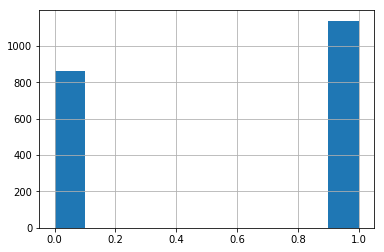

In [29]:
test.NewEstimateTotal.hist()

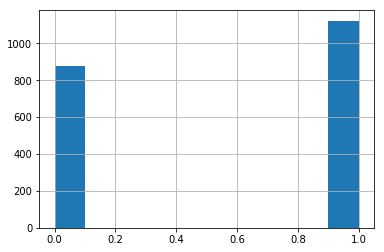

In [30]:
test.prediction.hist()